# Preprocessing(2) & Analysis 

## Importing Necessary Libraries

In [91]:
# General imports
import datetime as dt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sb

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Regression models
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from keras.regularizers import L2


# Deep learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam

from keras.layers import BatchNormalization

## Loading Data 

In [92]:
df = pd.read_csv('preprocessed_game_info.csv')

In [93]:
for column in df.columns:
    if df[column].dtype == 'object':
        try:
            df[column] = pd.to_numeric(df[column])
        except ValueError:
            print(f"Conversion failed for column: {column}")

Conversion failed for column: NAME
Conversion failed for column: DEVELOPERS


In [94]:
technologies = [col for col in df.columns if col.startswith('TECH')]
genres = [col for col in df.columns if col.startswith('GENRE')]
platforms = [col for col in df.columns if col.startswith('OS')]

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(exclude=['object']).columns.tolist()

categorical_features = [col for col in categorical_features if col not in technologies + genres + platforms]
numerical_features = [col for col in numerical_features if col not in technologies + genres + platforms]

label_encoders = {}
for column in ['NAME', 'DEVELOPERS']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    
# print("Technologies:", technologies)
# print("Genres:", genres)
# print("Platforms:", platforms)
# print("Categorical Features:", categorical_features)
# print("Numerical Features:", numerical_features)

## Initial Data Exploration

In [95]:
df.head()

NAME  N_SUPPORTED_LANGUAGES  DEVELOPERS  POSITIVE_REVIEWS  \
0   470                      7         205             39271   
1   614                     24         999            156683   
2  1729                      1        1067               872   
3   894                     12         149             22766   
4  1587                      1        1528               834   

   NEGATIVE_REVIEWS  PRICE  24_HOUR_PEAK  PUBLISH_YEAR  RATING_SCORE  \
0              5015    NaN        1064.0          2016      0.886759   
1             21075    NaN       16131.0          2021      0.881440   
2                70   4.99          21.0          2021      0.925690   
3              2819    NaN          31.0          2016      0.889818   
4                66    NaN         318.0          2023      0.926667   

   TOTAL_RATE_SUM  ...  GENRE: Indie  GENRE: Massively Multiplayer  \
0           44286  ...             0                             0   
1          177758  ...             0                             0   
2             942  ...             1                             0   
3           25585  ...             1                             0   
4             900  ...             1                             0   

   GENRE: RPG  GENRE: Racing  GENRE: Simulation  GENRE: Sports  \
0           1              0                  0              0   
1           0              1                  1              1   
2           0              0                  1              0   
3           0              0                  0              0   
4           0              0                  0              0   

   GENRE: Strategy  OS: Linux  OS: Windows  OS: macOS  
0                0          0            1          0  
1                0          0            1          0  
2                0          1            1          0  
3                0          1            1          1  
4                0          0            1          0  

[5 rows x 165 columns]

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Columns: 165 entries, NAME to OS: macOS
dtypes: float64(4), int32(2), int64(159)
memory usage: 2.5 MB


## Plot the Count of Unique Values for Each Feature 

In [97]:
unique_counts_categorical = df[categorical_features].nunique()
unique_counts_numerical = df[numerical_features].nunique()

tech_count = len(technologies)
genre_count = len(genres)
platform_count = len(platforms)

counts = pd.concat([unique_counts_categorical, unique_counts_numerical])
counts['Technologies'] = tech_count
counts['Genres'] = genre_count
counts['Platforms'] = platform_count

feature_colors = sns.color_palette('hls', n_colors=len(categorical_features) + len(numerical_features) + 3)
features = counts.index.tolist()
feature_color_map = dict(zip(features, feature_colors))
colors = [feature_color_map[feature] for feature in features]


In [98]:
features

['NAME',
 'DEVELOPERS',
 'N_SUPPORTED_LANGUAGES',
 'POSITIVE_REVIEWS',
 'NEGATIVE_REVIEWS',
 'PRICE',
 '24_HOUR_PEAK',
 'PUBLISH_YEAR',
 'RATING_SCORE',
 'TOTAL_RATE_SUM',
 'TWITCH_PEAK_HOUR',
 'TWITCH_PEAK_YEAR',
 'Technologies',
 'Genres',
 'Platforms']

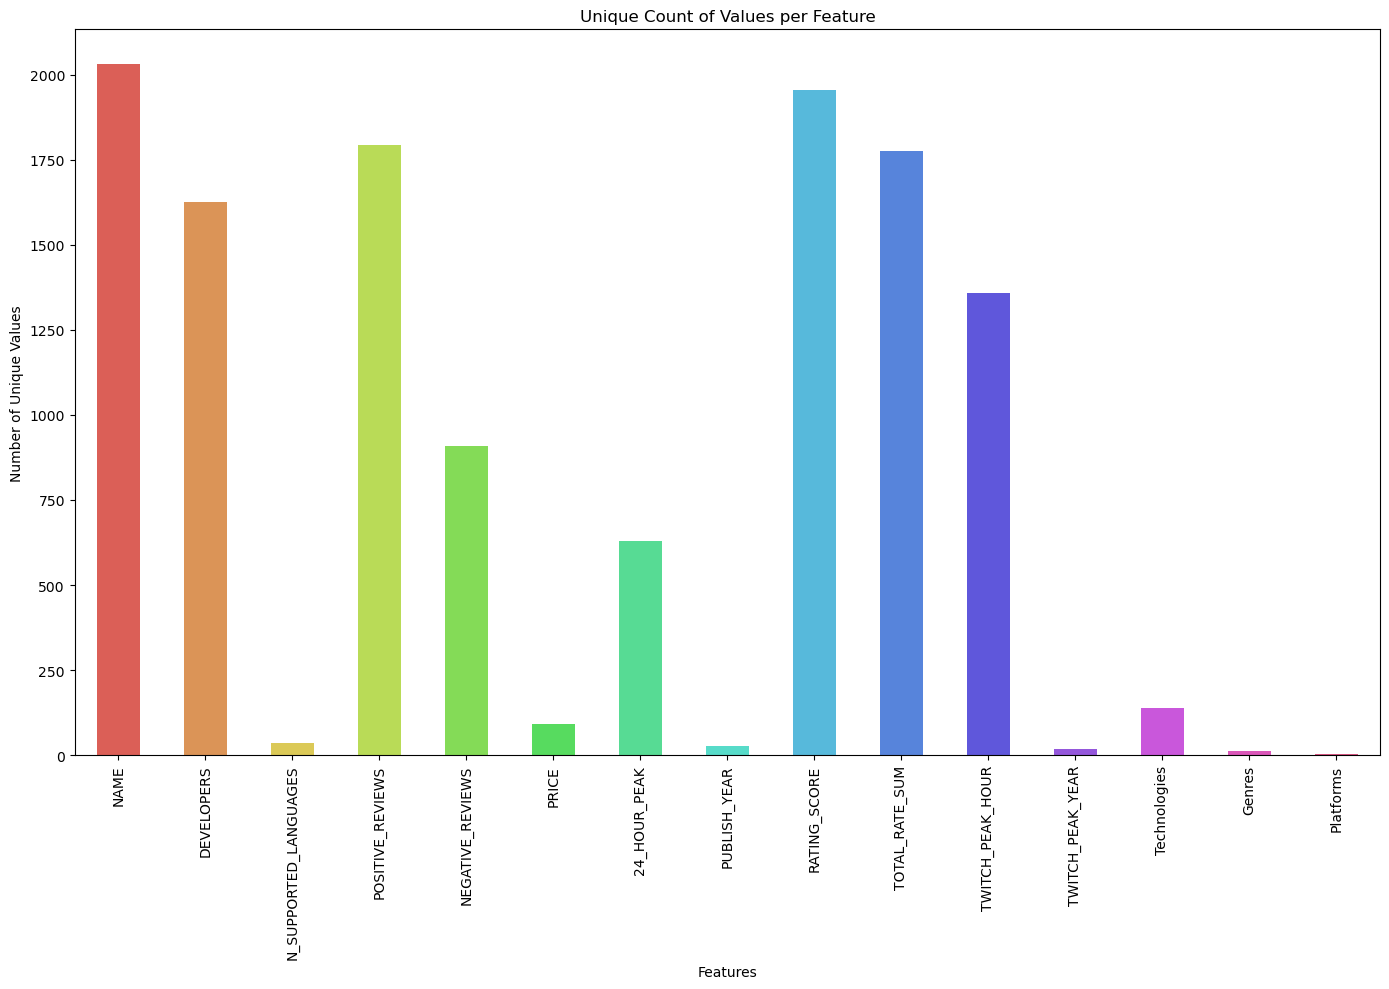

In [99]:
plt.figure(figsize=(14, 10))
counts.plot(kind='bar', color=colors)
plt.title('Unique Count of Values per Feature')
plt.xlabel('Features')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Outlier Detection and Handling

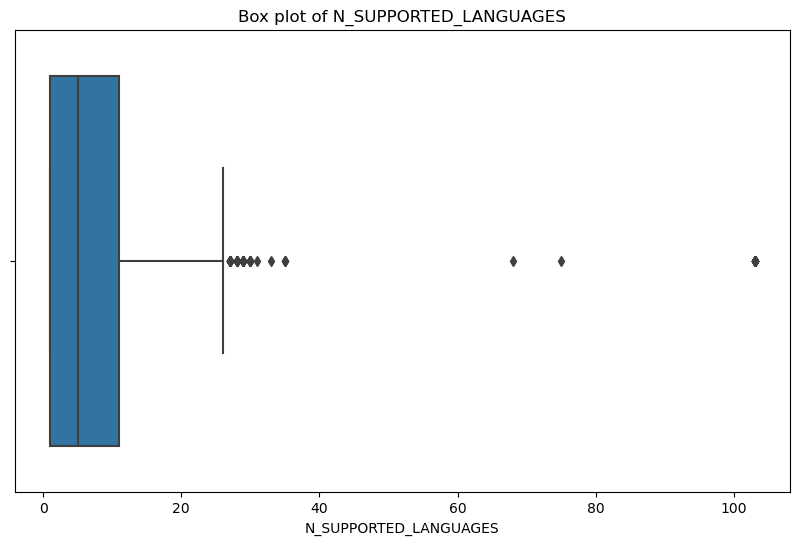

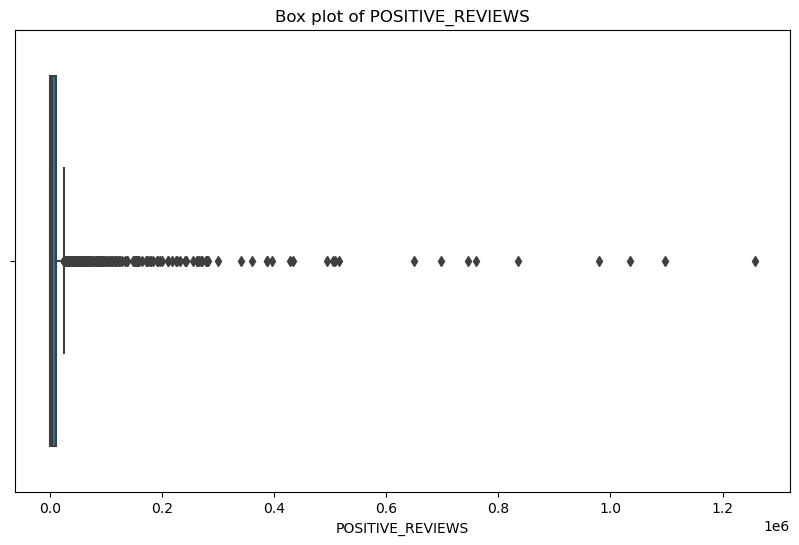

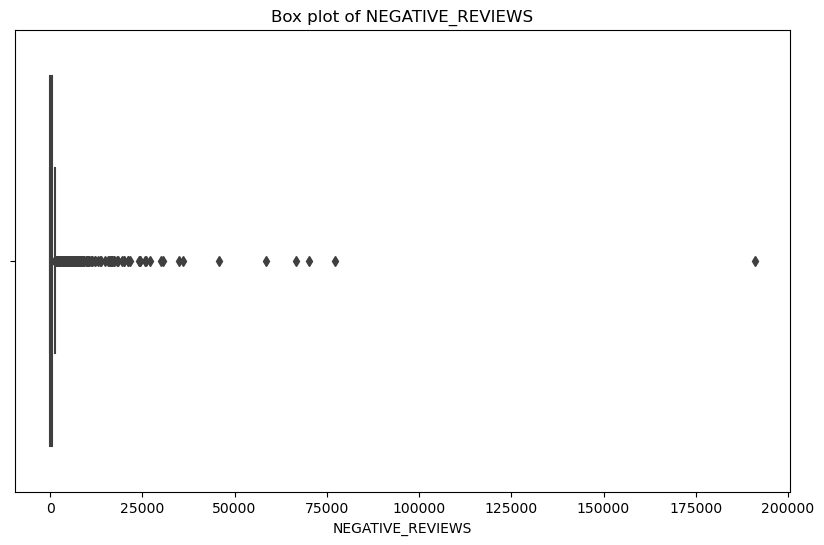

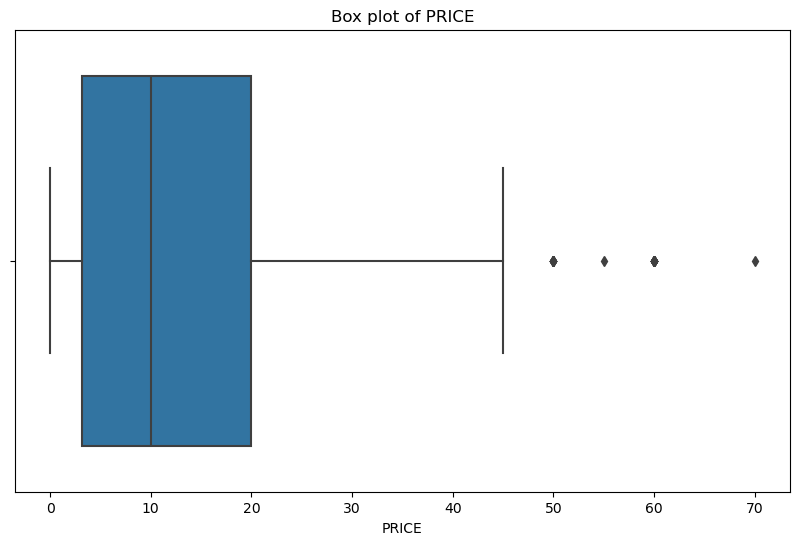

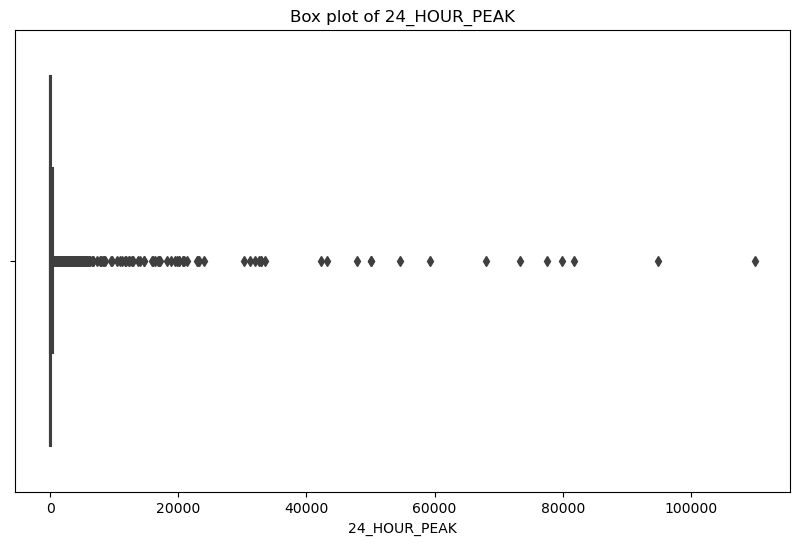

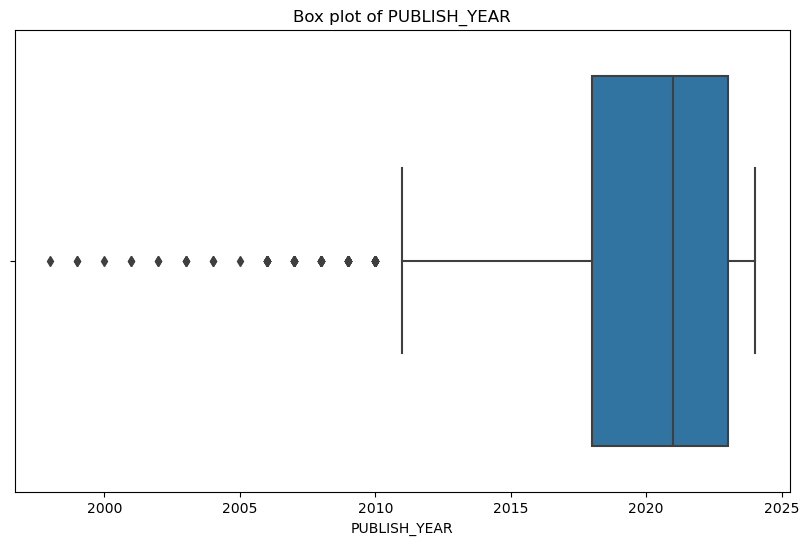

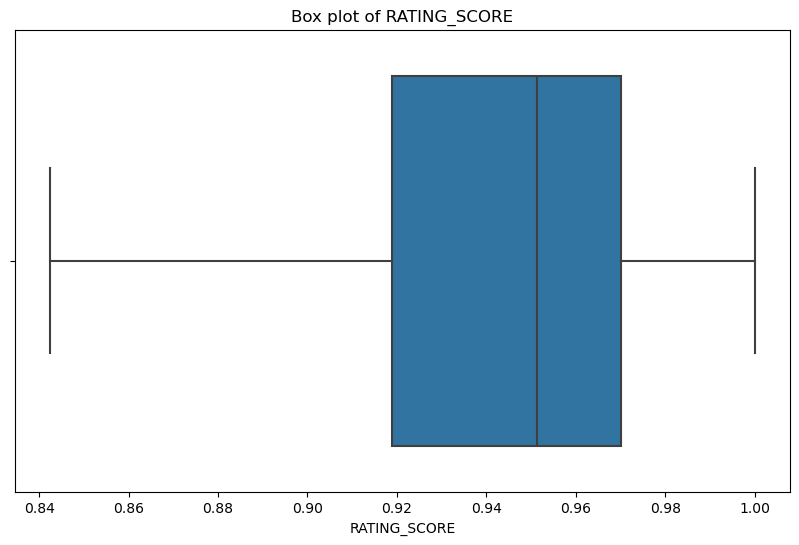

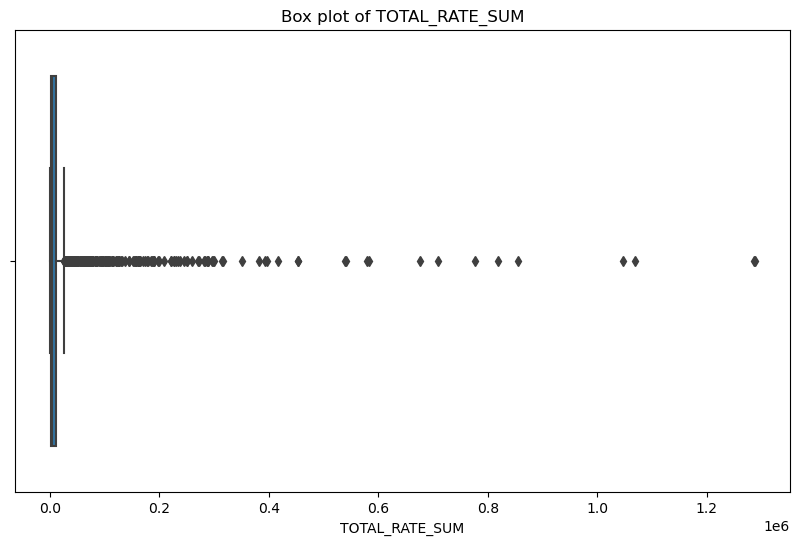

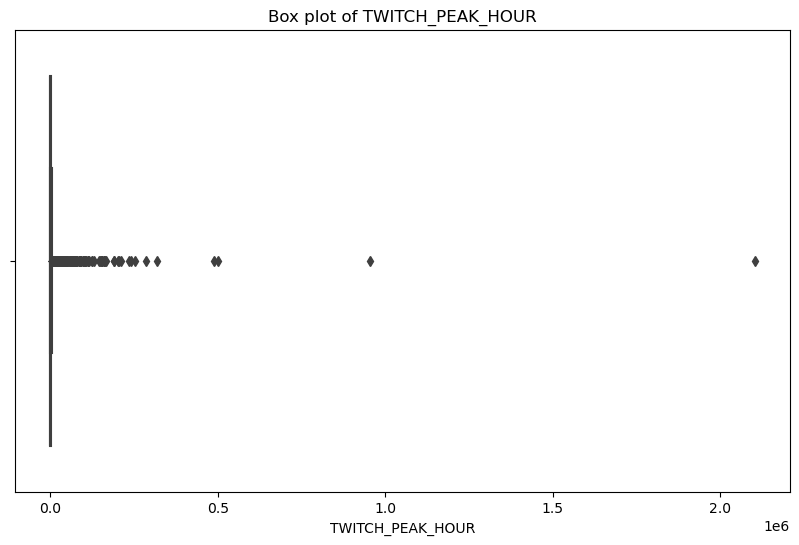

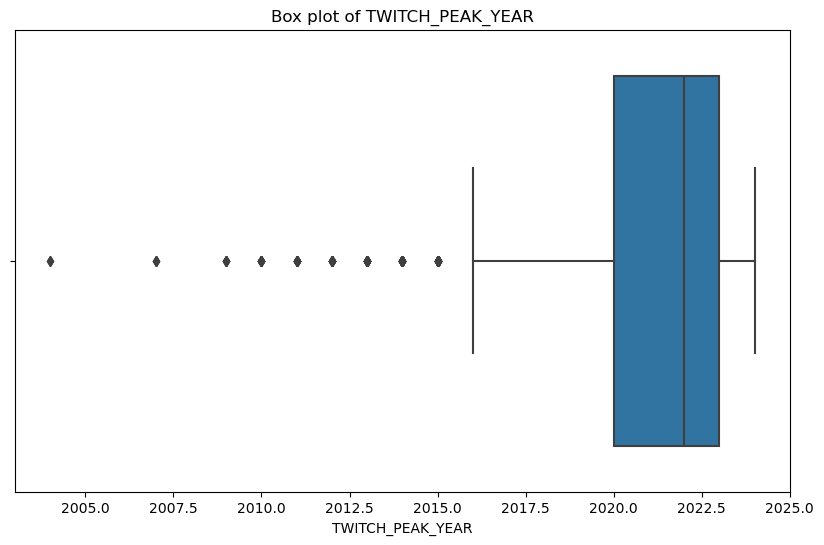

In [100]:
methods = {}

for column in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()

    mean = df[column].mean()
    median = df[column].median()
    std = df[column].std()
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    
    if len(outliers) / len(df) < 0.05:
        if abs(mean - median) / std > 0.5:
            methods[column] = 'transform'
        else:
            methods[column] = 'remove'
    else:
        methods[column] = 'cap'

In [101]:
methods

{'N_SUPPORTED_LANGUAGES': 'remove',
 'POSITIVE_REVIEWS': 'cap',
 'NEGATIVE_REVIEWS': 'cap',
 'PRICE': 'remove',
 '24_HOUR_PEAK': 'cap',
 'PUBLISH_YEAR': 'remove',
 'RATING_SCORE': 'remove',
 'TOTAL_RATE_SUM': 'cap',
 'TWITCH_PEAK_HOUR': 'cap',
 'TWITCH_PEAK_YEAR': 'cap'}

**Outlier Handling Suggestions:**
- Transform: Suggested if there is a significant skew in the data (mean and median are far apart relative to the standard deviation).
- Remove: Suggested if the number of outliers is low and the data distribution is not heavily skewed.
- Cap: Suggested if the number of outliers is high, indicating that simply removing them might lead to loss of significant data.

In [102]:
# def handle_outliers(df, methods, exclude_columns=[]):

#     df_cleaned = df.copy()  
    
#     for column, method in methods.items():
#         if column in exclude_columns:
#             continue
        
#         Q1 = df_cleaned[column].quantile(0.25)
#         Q3 = df_cleaned[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         if method == 'remove':
#             df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
#         elif method == 'cap':
#             df_cleaned[column] = df_cleaned[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
#         elif method == 'transform':
#             df_cleaned[column] = np.log1p(df_cleaned[column])  
#         else:
#             raise ValueError("Method must be either 'remove', 'cap', or 'transform'")
    
#     return df_cleaned

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Columns: 165 entries, NAME to OS: macOS
dtypes: float64(4), int32(2), int64(159)
memory usage: 2.5 MB


# Feature Engineering and Selection (Analysis) 

In [104]:
target_column = '24_HOUR_PEAK'

## Correlation Heatmap

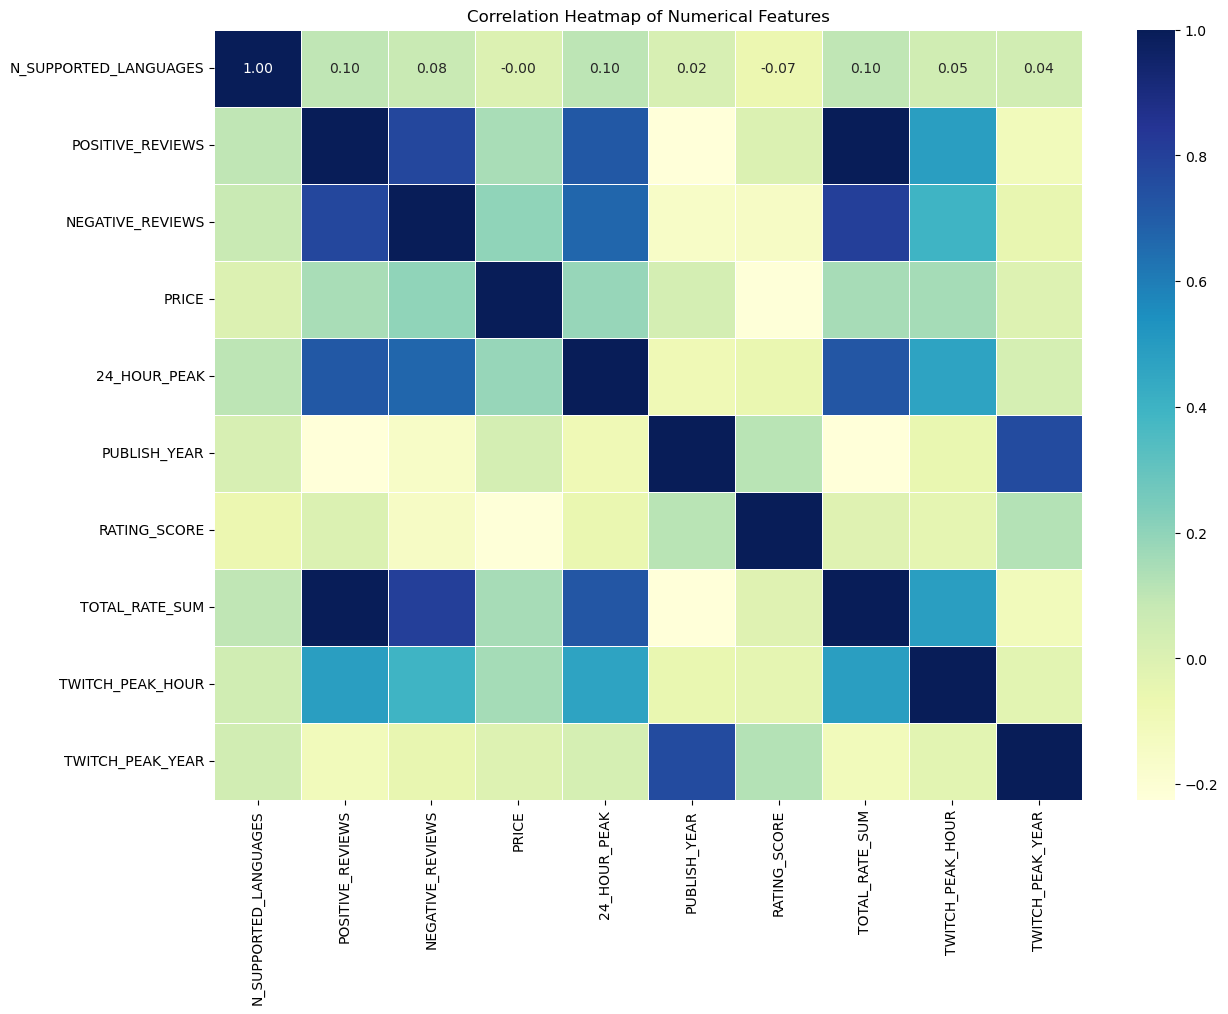

In [105]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [106]:
correlations_with_target = df[numerical_features + [target_column]].corr()[target_column].drop(target_column)

print("Correlation of numerical features with the target variable '24_HOUR_PEAK':")
print(correlations_with_target)


Correlation of numerical features with the target variable '24_HOUR_PEAK':
                       24_HOUR_PEAK  24_HOUR_PEAK
N_SUPPORTED_LANGUAGES      0.102634      0.102634
POSITIVE_REVIEWS           0.713983      0.713983
NEGATIVE_REVIEWS           0.667456      0.667456
PRICE                      0.185387      0.185387
PUBLISH_YEAR              -0.087232     -0.087232
RATING_SCORE              -0.059560     -0.059560
TOTAL_RATE_SUM             0.721471      0.721471
TWITCH_PEAK_HOUR           0.465874      0.465874
TWITCH_PEAK_YEAR           0.027272      0.027272


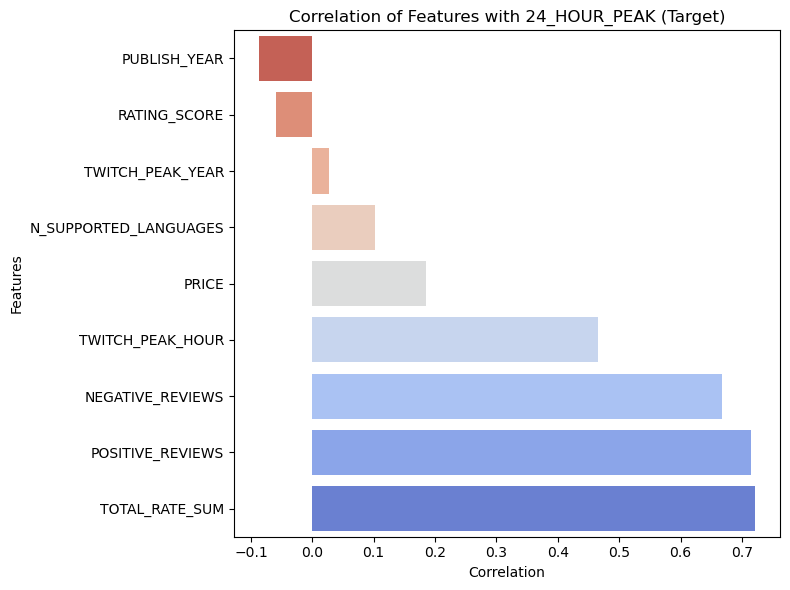

In [107]:
target_correlation = correlation_matrix['24_HOUR_PEAK'].drop('24_HOUR_PEAK').sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(y=target_correlation.index, x=target_correlation, palette='coolwarm_r', orient='h')
plt.title('Correlation of Features with 24_HOUR_PEAK (Target)')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## Histograms

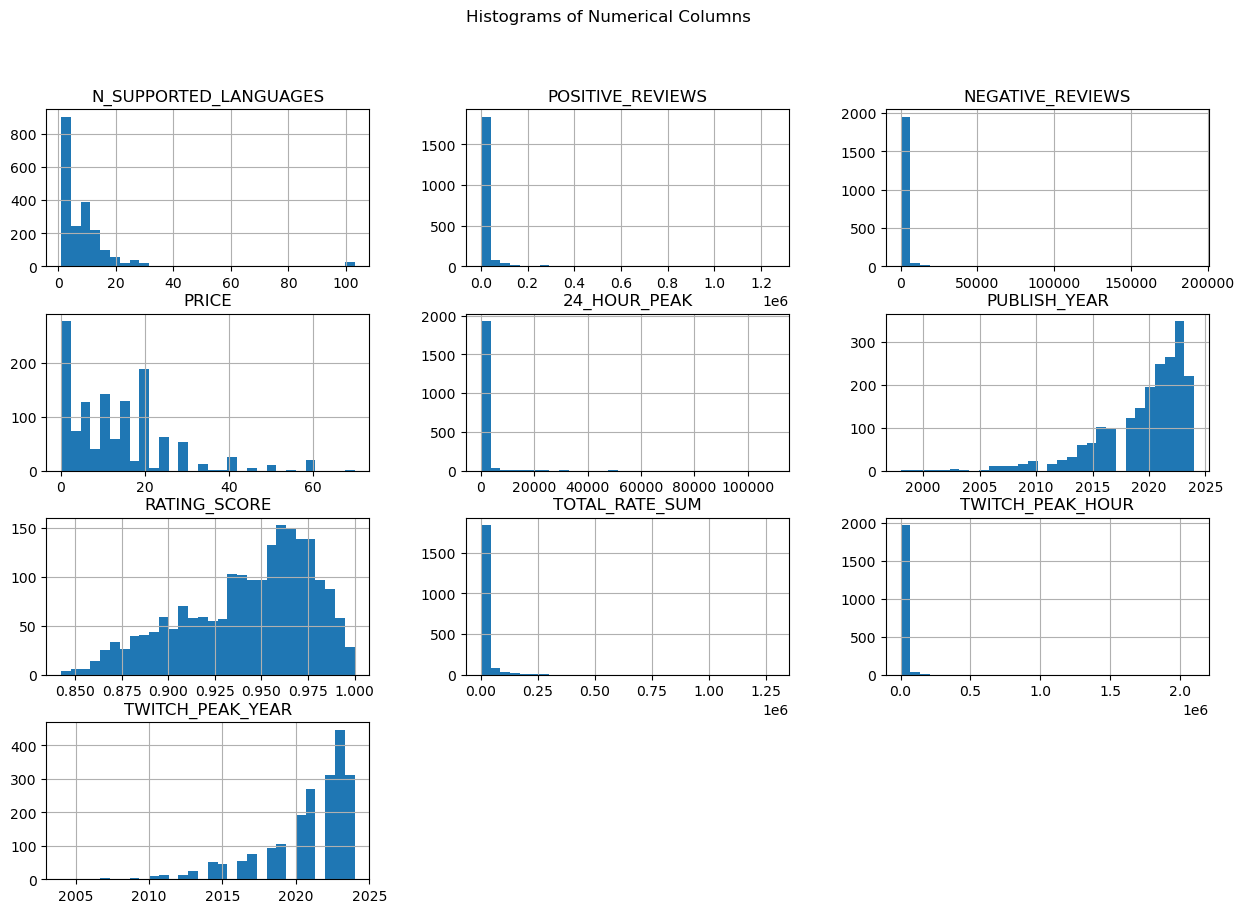

In [108]:
df[numerical_features].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Columns")
plt.show()

##  Plot pair plot

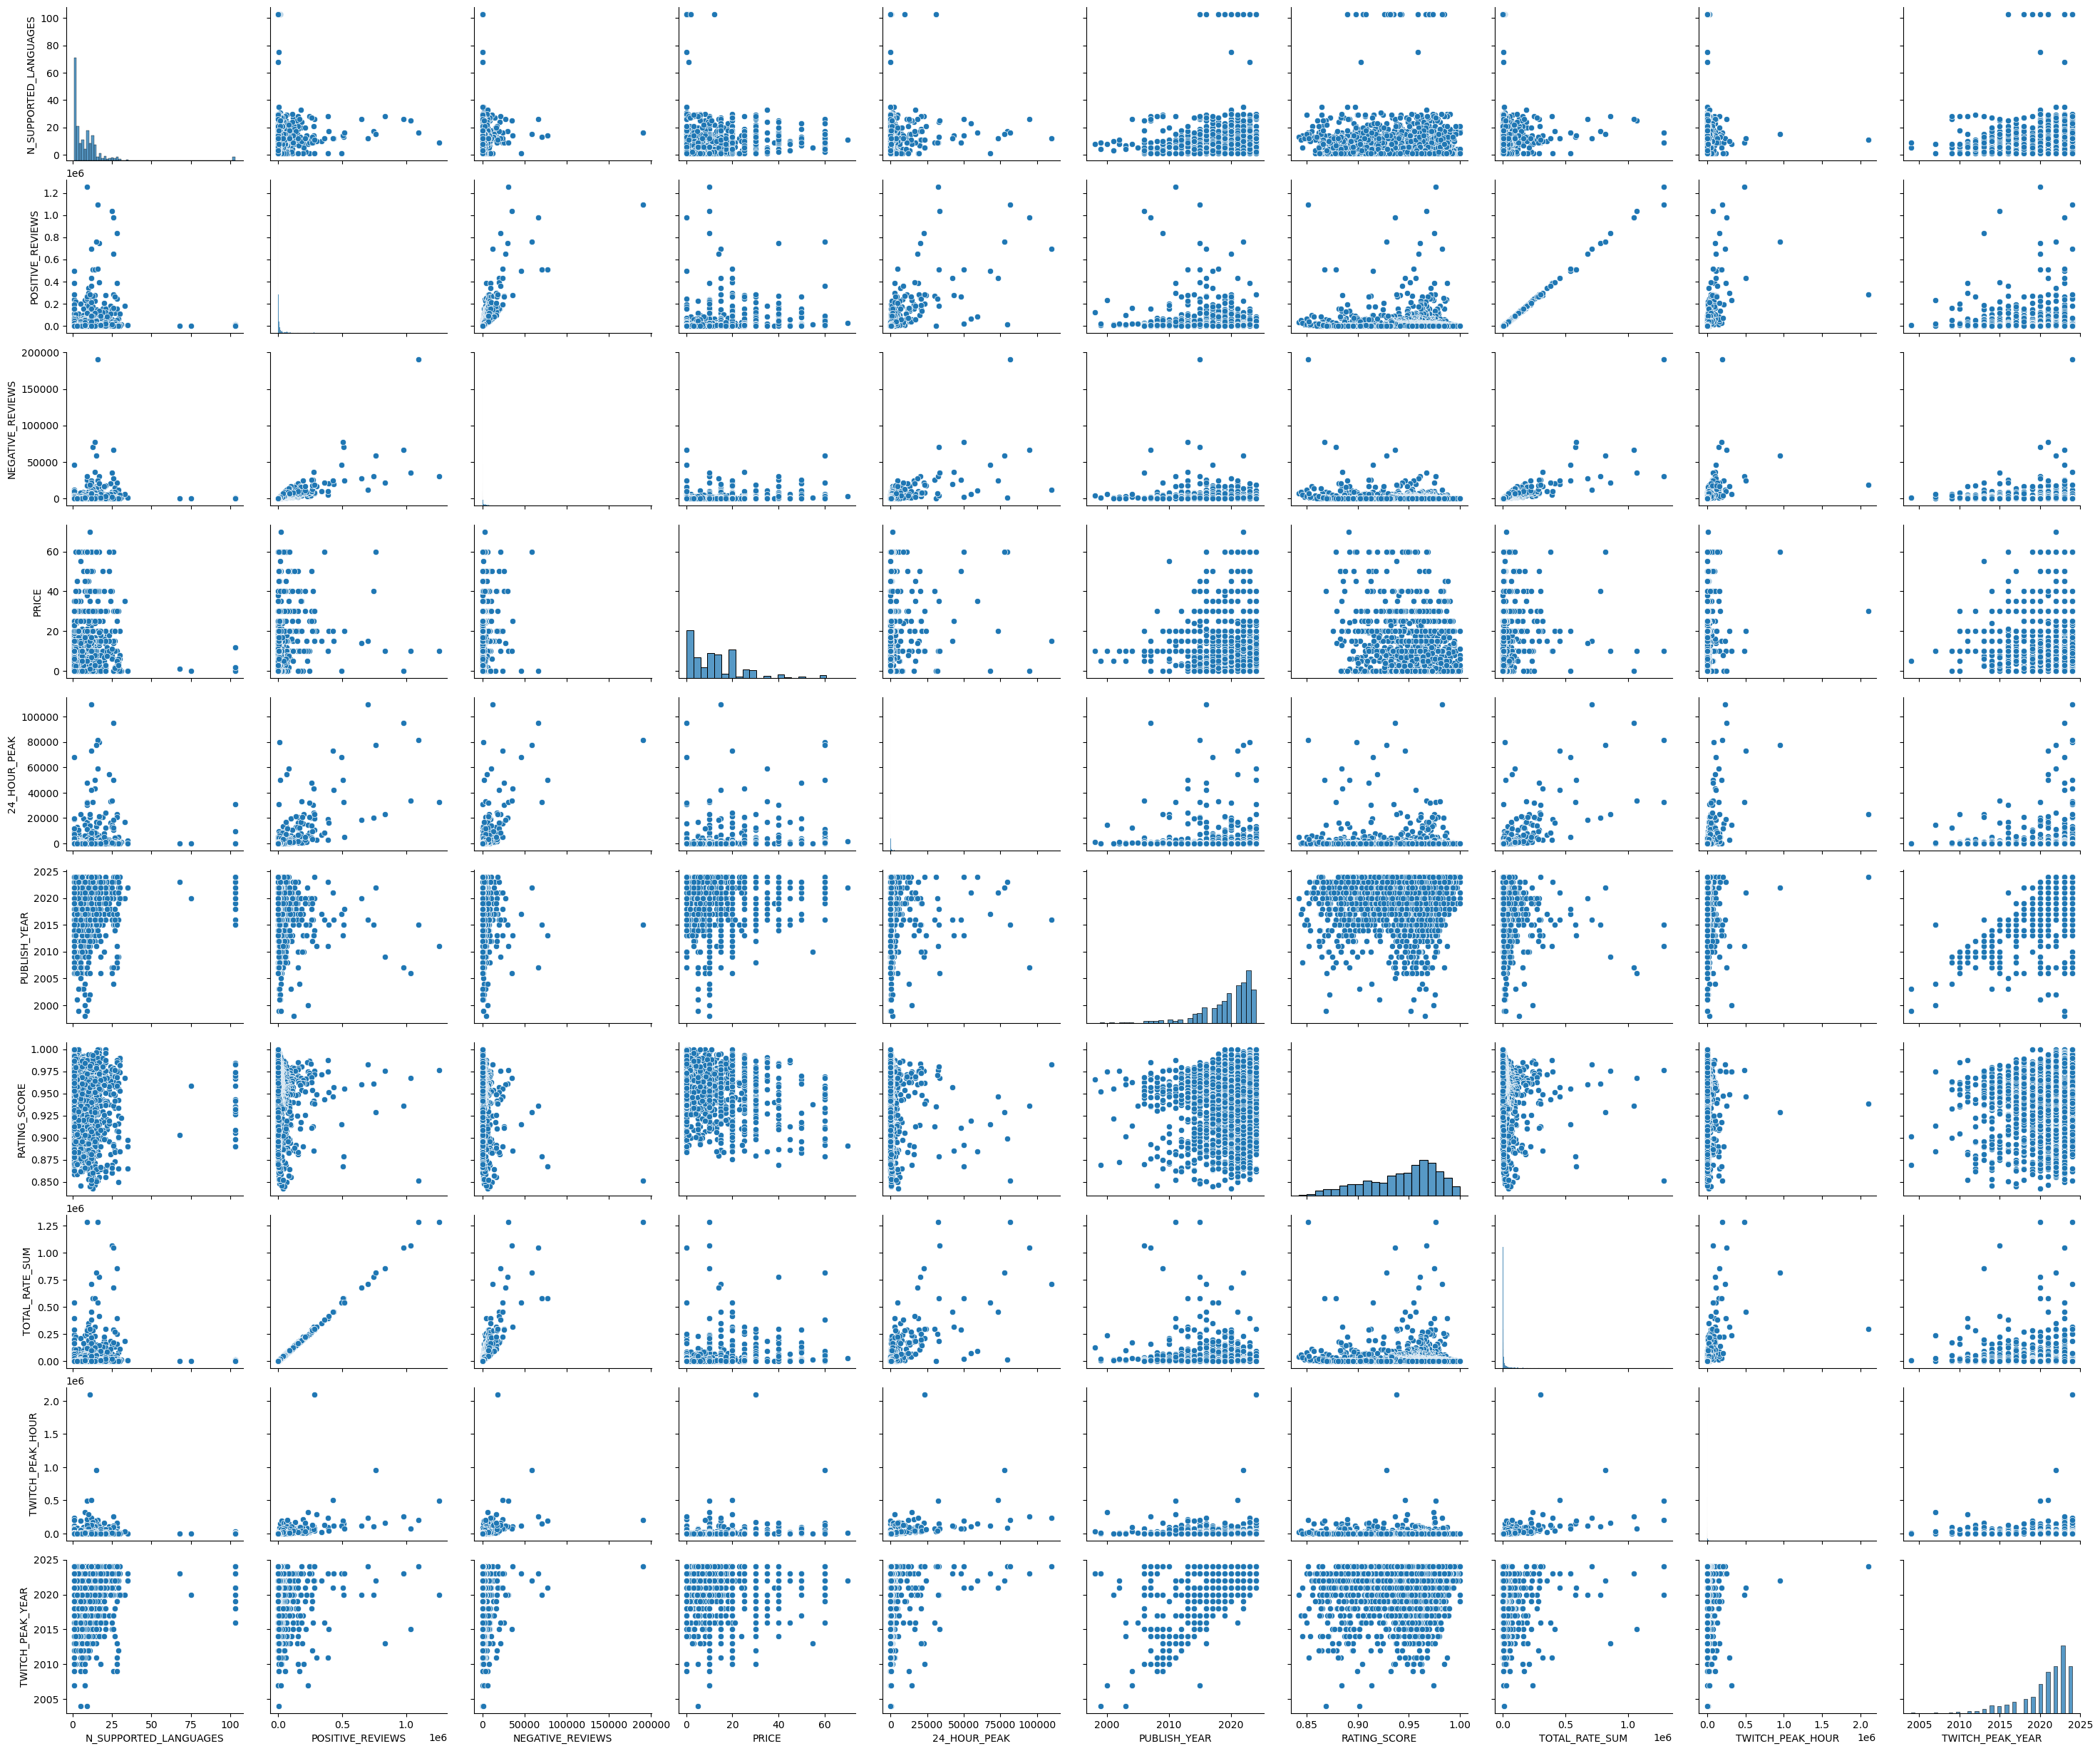

In [109]:
sns.pairplot(df[numerical_features], height=2.5, aspect=1.2)
plt.show()

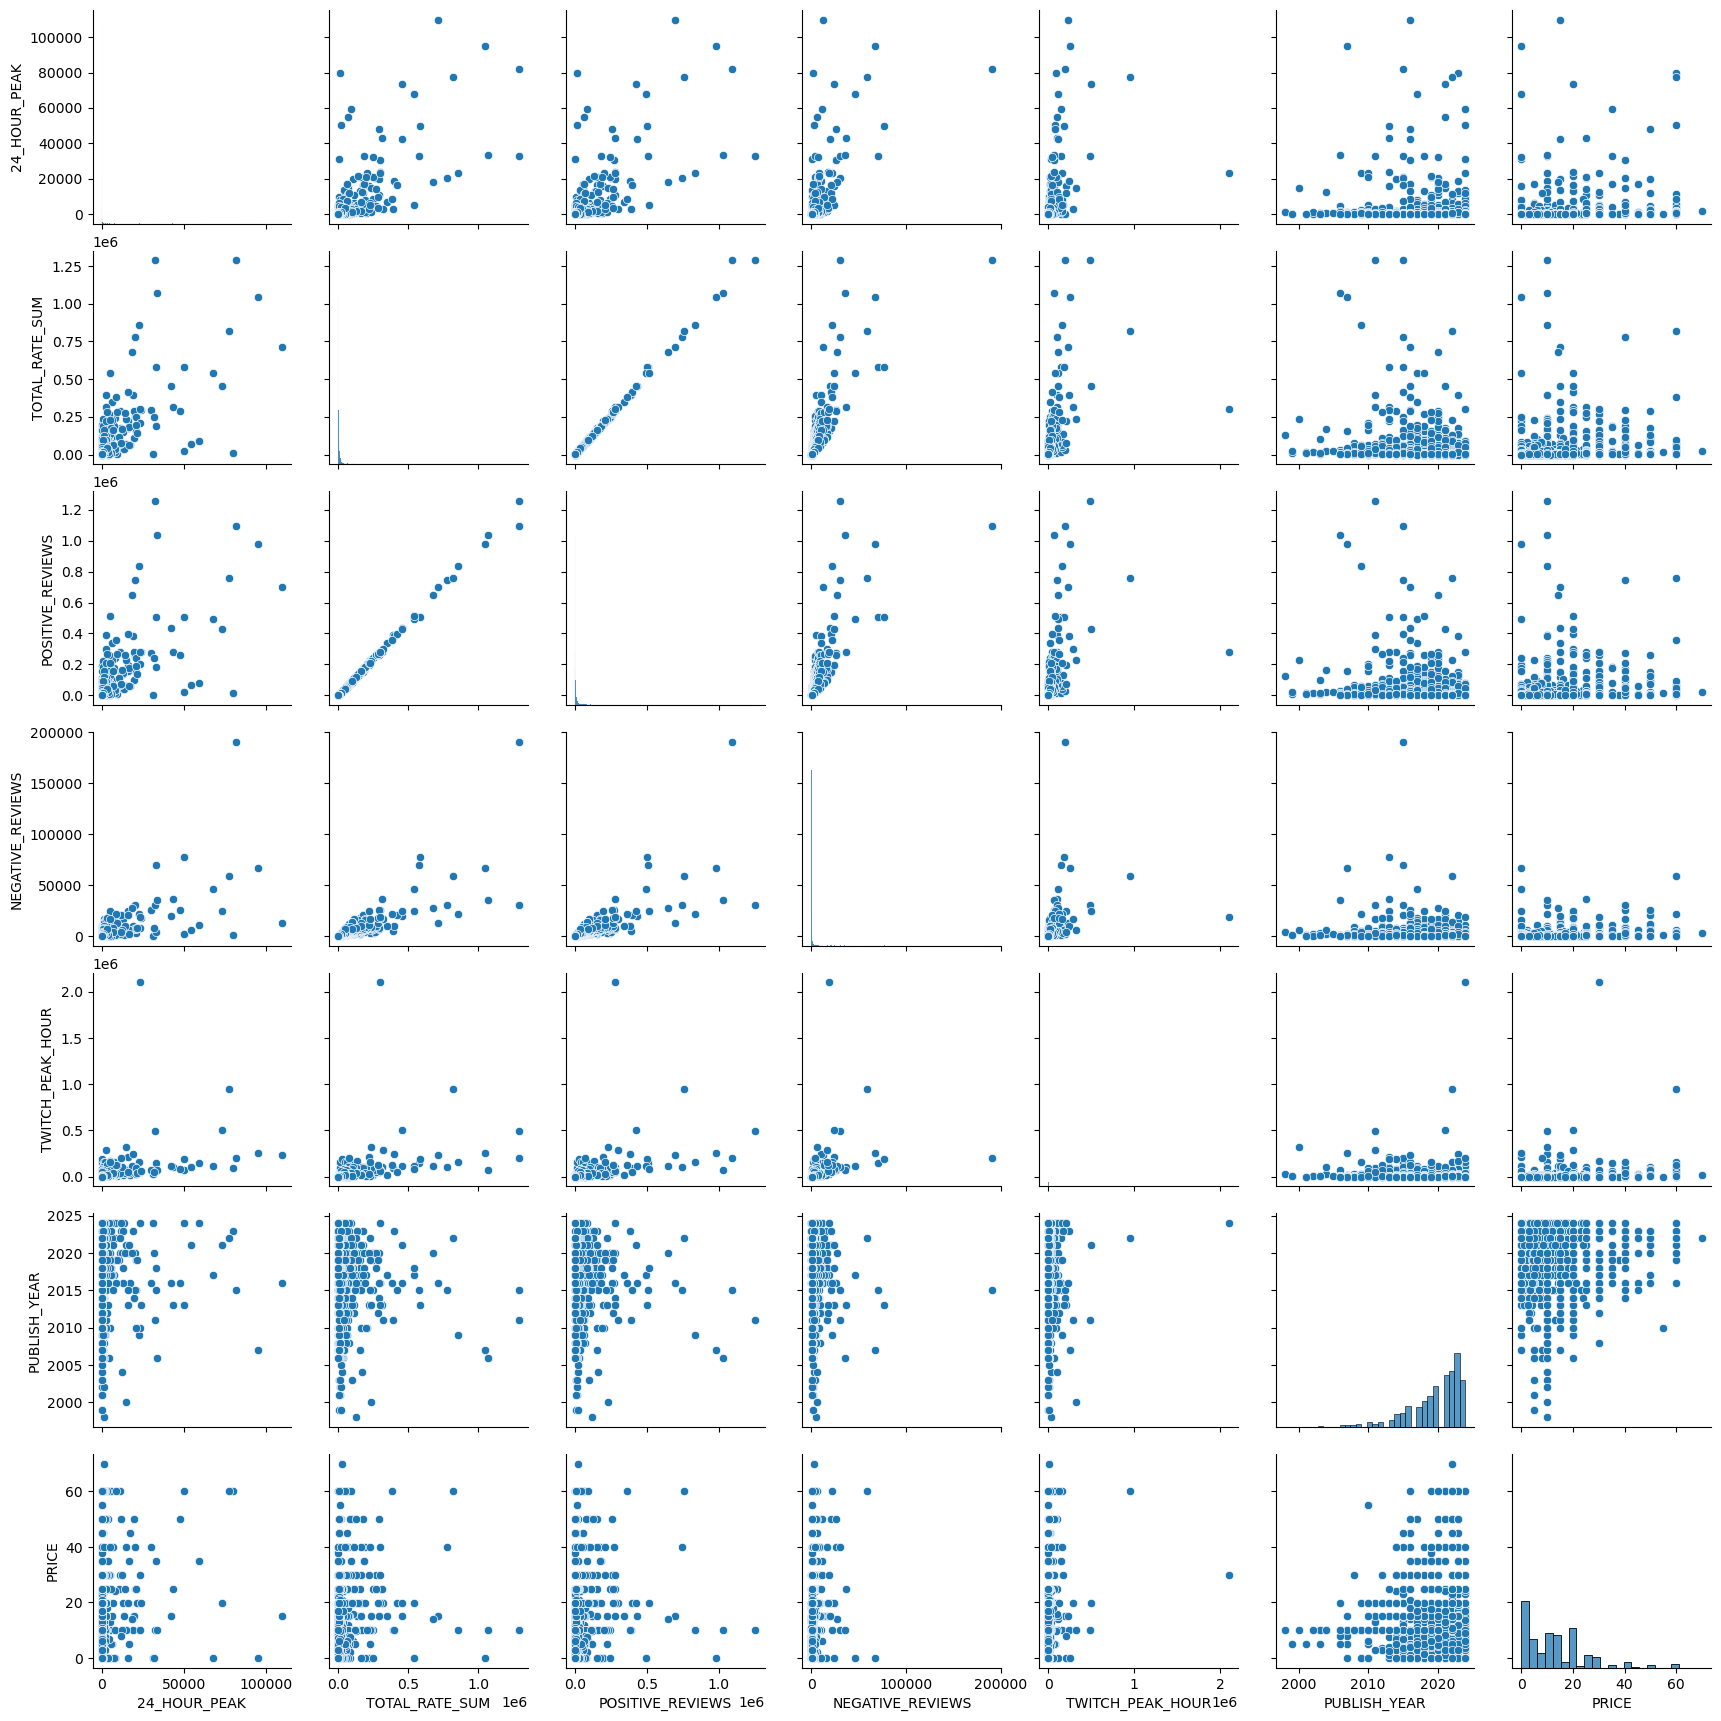

In [110]:
selected_features = ['24_HOUR_PEAK', 'TOTAL_RATE_SUM', 'POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'TWITCH_PEAK_HOUR', 'PUBLISH_YEAR', 'PRICE']

sns.pairplot(df[selected_features])
plt.show()

## Summary statistics for the `24_HOUR_PEAK` column

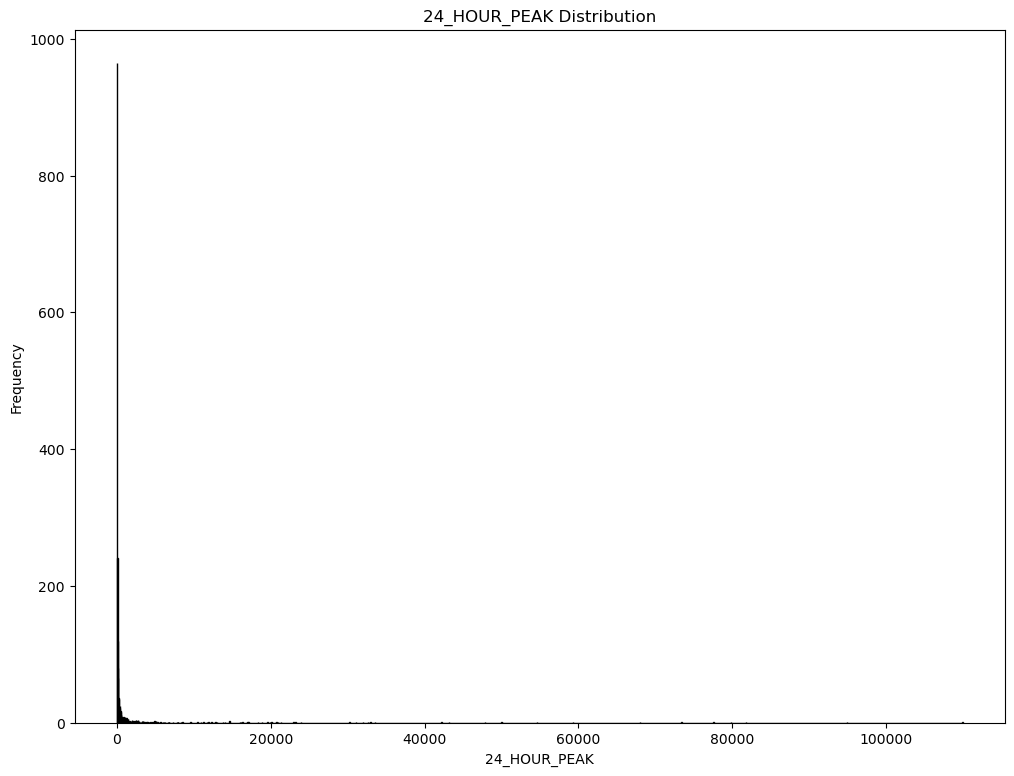

In [111]:
plt.hist(df['24_HOUR_PEAK'], bins='auto', color=feature_color_map['24_HOUR_PEAK'], edgecolor='black')
plt.xlabel('24_HOUR_PEAK')
plt.ylabel('Frequency')
plt.title('24_HOUR_PEAK Distribution')
plt.show()

In [112]:
df['24_HOUR_PEAK'].describe()

count      2032.000000
mean       1185.736713
std        6441.760299
min           0.000000
25%          10.000000
50%          36.500000
75%         210.000000
max      109950.000000
Name: 24_HOUR_PEAK, dtype: float64

## Log Transformation (`24_HOUR_PEAK`)

In [113]:
if 'log_24_HOUR_PEAK' not in df.columns:
    df['log_24_HOUR_PEAK'] = np.log1p(df['24_HOUR_PEAK'])
    numerical_features.append('log_24_HOUR_PEAK')

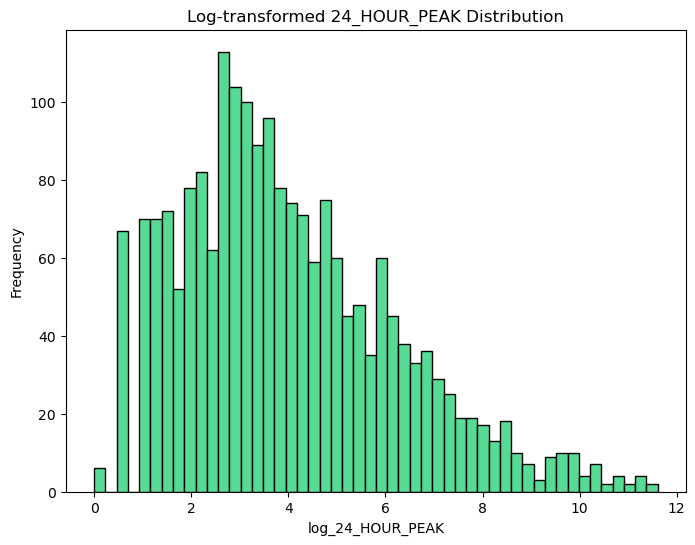

In [114]:
plt.figure(figsize=(8, 6))
plt.hist(df['log_24_HOUR_PEAK'], bins=50, color=feature_color_map['24_HOUR_PEAK'], edgecolor='black')
plt.title('Log-transformed 24_HOUR_PEAK Distribution')
plt.xlabel('log_24_HOUR_PEAK')
plt.ylabel('Frequency')
plt.show()

In [115]:
df['log_24_HOUR_PEAK'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2032 entries, 0 to 2031
Series name: log_24_HOUR_PEAK
Non-Null Count  Dtype  
--------------  -----  
2032 non-null   float64
dtypes: float64(1)
memory usage: 16.0 KB


In [116]:
df['log_24_HOUR_PEAK'].isnull().sum()

0

## Summary statistics for the `PRICE` column

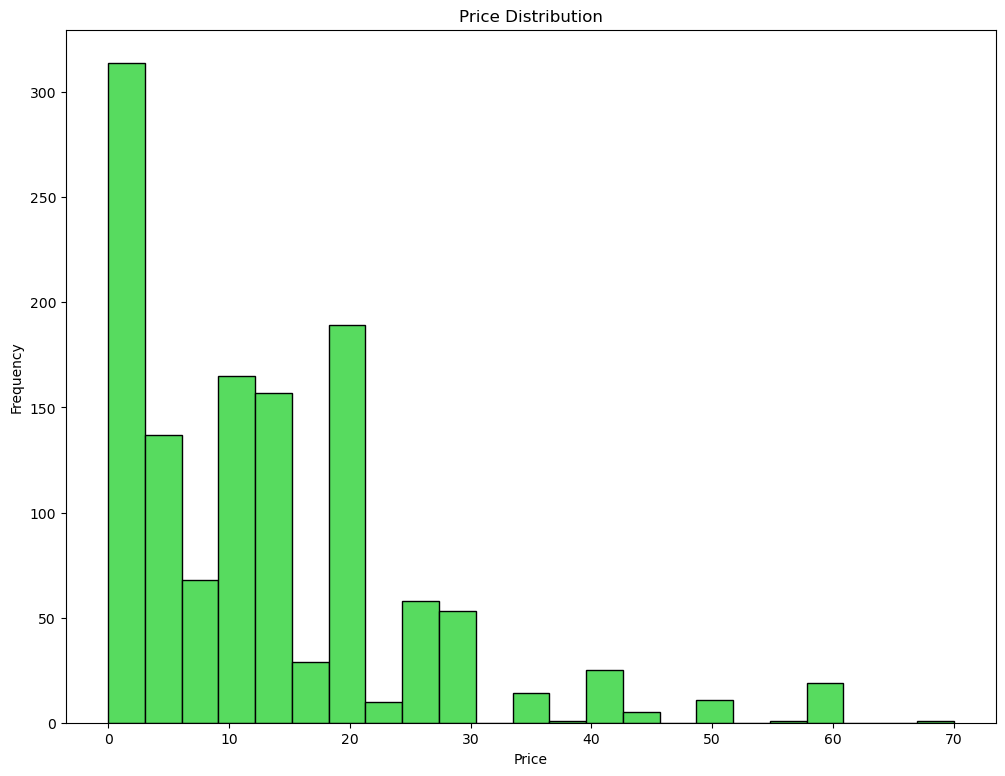

In [117]:
plt.hist(df['PRICE'], bins='auto', color=feature_color_map['PRICE'], edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

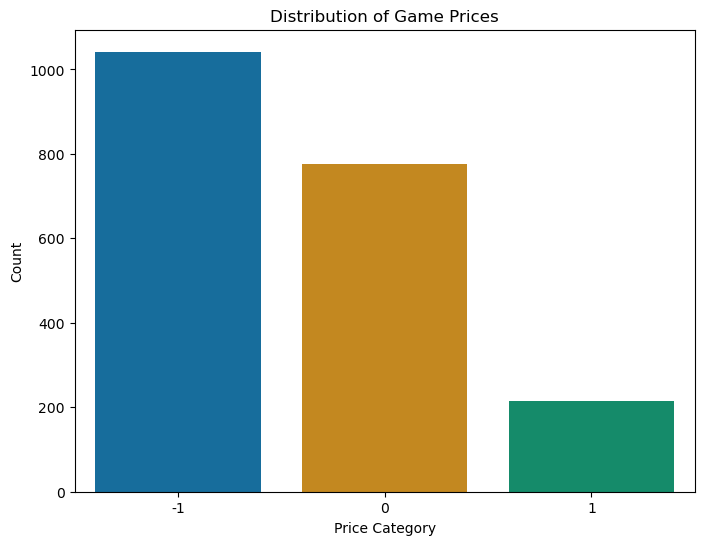

In [118]:
def categorize_price(price):
    if pd.isna(price):
        return 0
    elif price == 0:
        return 1
    else:
        return -1

df = df.assign(PRICE_CATEGORY=df['PRICE'].apply(categorize_price))

price_category_counts = df['PRICE_CATEGORY'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=price_category_counts.index, y=price_category_counts.values, palette='colorblind')

plt.xlabel('Price Category')
plt.ylabel('Count')
plt.title('Distribution of Game Prices')
plt.show()


In [119]:
df['PRICE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2032 entries, 0 to 2031
Series name: PRICE
Non-Null Count  Dtype  
--------------  -----  
1257 non-null   float64
dtypes: float64(1)
memory usage: 16.0 KB


In [120]:
df['PRICE'].describe()

count    1257.000000
mean       13.113294
std        12.243899
min         0.000000
25%         3.190000
50%         9.990000
75%        19.990000
max        69.990000
Name: PRICE, dtype: float64

In [121]:
df['PRICE'].isnull().sum()

775

##  Summary statistics for the `PUBLISH_YEAR` column

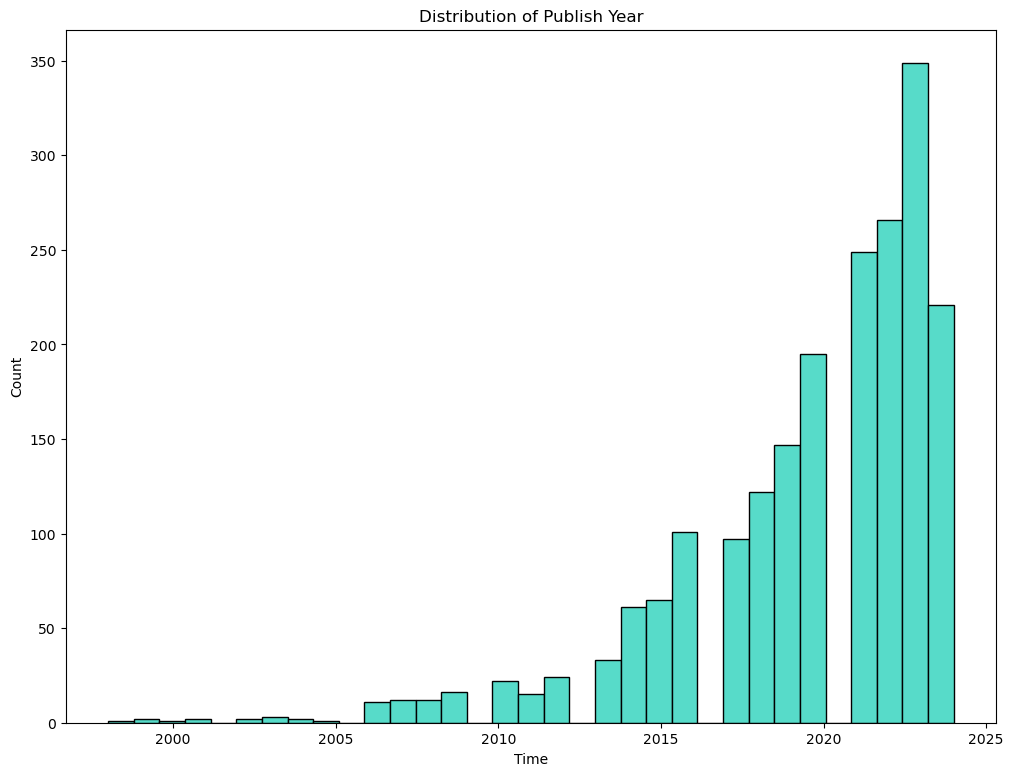

In [122]:
plt.hist(df['PUBLISH_YEAR'], bins='auto', color=feature_color_map['PUBLISH_YEAR'], edgecolor='black')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Distribution of Publish Year')
plt.show()

In [123]:
df['PUBLISH_YEAR'].describe()

count    2032.000000
mean     2019.641240
std         4.081244
min      1998.000000
25%      2018.000000
50%      2021.000000
75%      2023.000000
max      2024.000000
Name: PUBLISH_YEAR, dtype: float64

## Plot the average `24_HOUR_PEAK` for each year (`PUBLISH_YEAR`)

In [124]:
print(sorted(df["PUBLISH_YEAR"].unique()))

[1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


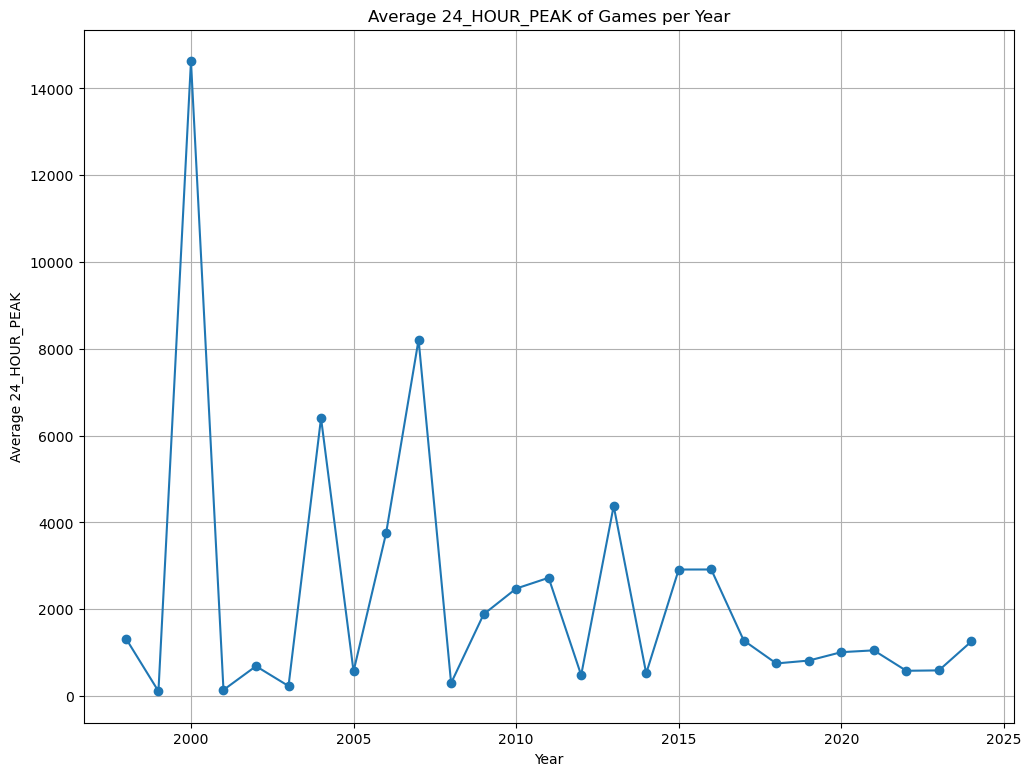

In [125]:
average_peak24_per_year = df.groupby('PUBLISH_YEAR')['24_HOUR_PEAK'].mean()

plt.plot(average_peak24_per_year.index, average_peak24_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Average 24_HOUR_PEAK')
plt.title('Average 24_HOUR_PEAK of Games per Year')
plt.grid(True)
plt.show()

## `Platform` Analysis

OS: Linux 2034.064833005894
OS: Windows 1185.7367125984251
OS: macOS 1597.2536520584329


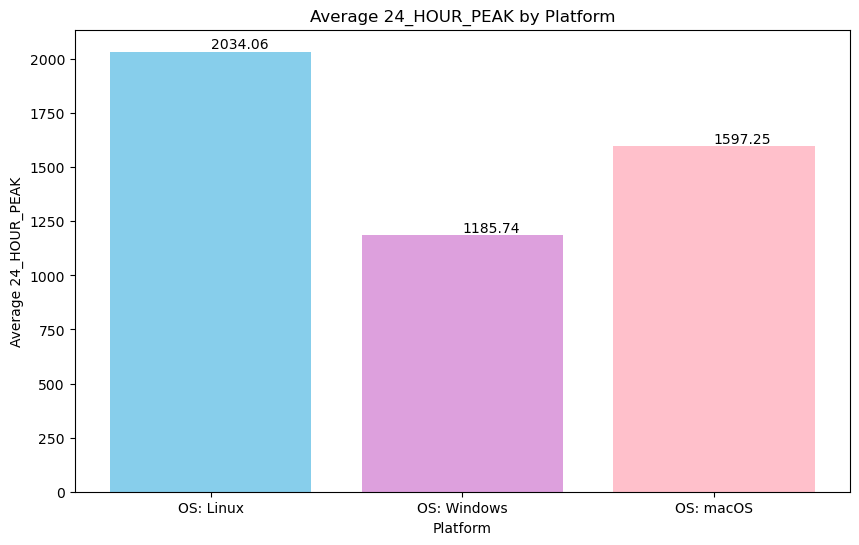

In [126]:
averages = []
for platform in platforms:
    avg = df.loc[df[platform] == 1, '24_HOUR_PEAK'].mean()
    averages.append(avg)
    print(platform, avg)
colors = ['skyblue', 'plum', 'pink']

plt.figure(figsize=(10, 6))
bars = plt.bar(platforms, averages, color=colors)

for bar, avg in zip(bars, averages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(avg, 2), va='bottom')  # va: vertical alignment

plt.title('Average 24_HOUR_PEAK by Platform')
plt.xlabel('Platform')
plt.ylabel('Average 24_HOUR_PEAK')
plt.show()

del averages


In [127]:
df['PLATFORM_COUNT'] = df[platforms].sum(axis=1)
numerical_features.append('PLATFORM_COUNT')

platform_groups = df.groupby('PLATFORM_COUNT').agg({
    '24_HOUR_PEAK': 'mean'
})

platform_groups.reset_index(inplace=True)

platform_groups

PLATFORM_COUNT  24_HOUR_PEAK
0               1    891.025556
1               2   1114.720745
2               3   2052.975169

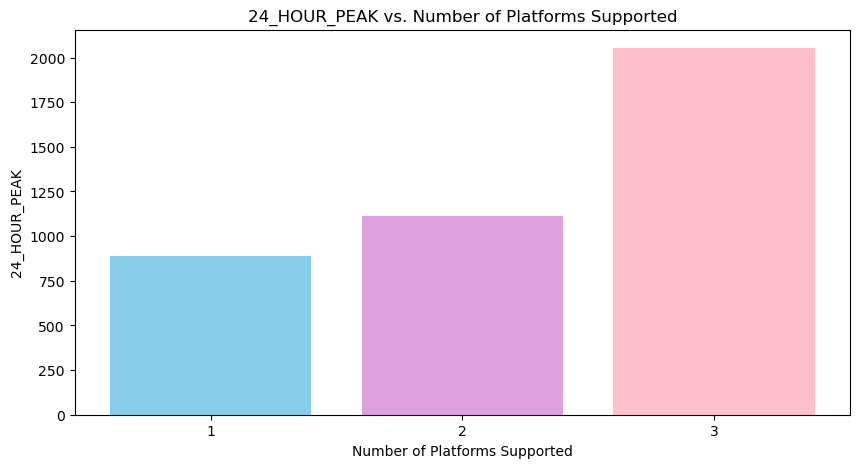

In [128]:
colors = ['skyblue', 'plum', 'pink']
metrics = ['24_HOUR_PEAK']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(platform_groups['PLATFORM_COUNT'], platform_groups[metric], color=colors)
    plt.xlabel('Number of Platforms Supported')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Number of Platforms Supported')
    plt.xticks(range(1, 4))
    plt.show()

##  Relation between `24_HOUR_PEAK` and `STORE_GENRE`

GENRE: Action 1684.2761104441777
GENRE: Adventure 846.6421052631579
GENRE: Casual 497.15686274509807
GENRE: Early Access 1883.779761904762
GENRE: Free to Play 1593.5118110236222
GENRE: Indie 815.6311475409836
GENRE: Massively Multiplayer 5630.611111111111
GENRE: RPG 2044.4896073903003
GENRE: Racing 1816.388888888889
GENRE: Simulation 1857.577731092437
GENRE: Sports 3348.6666666666665
GENRE: Strategy 1770.7415384615385


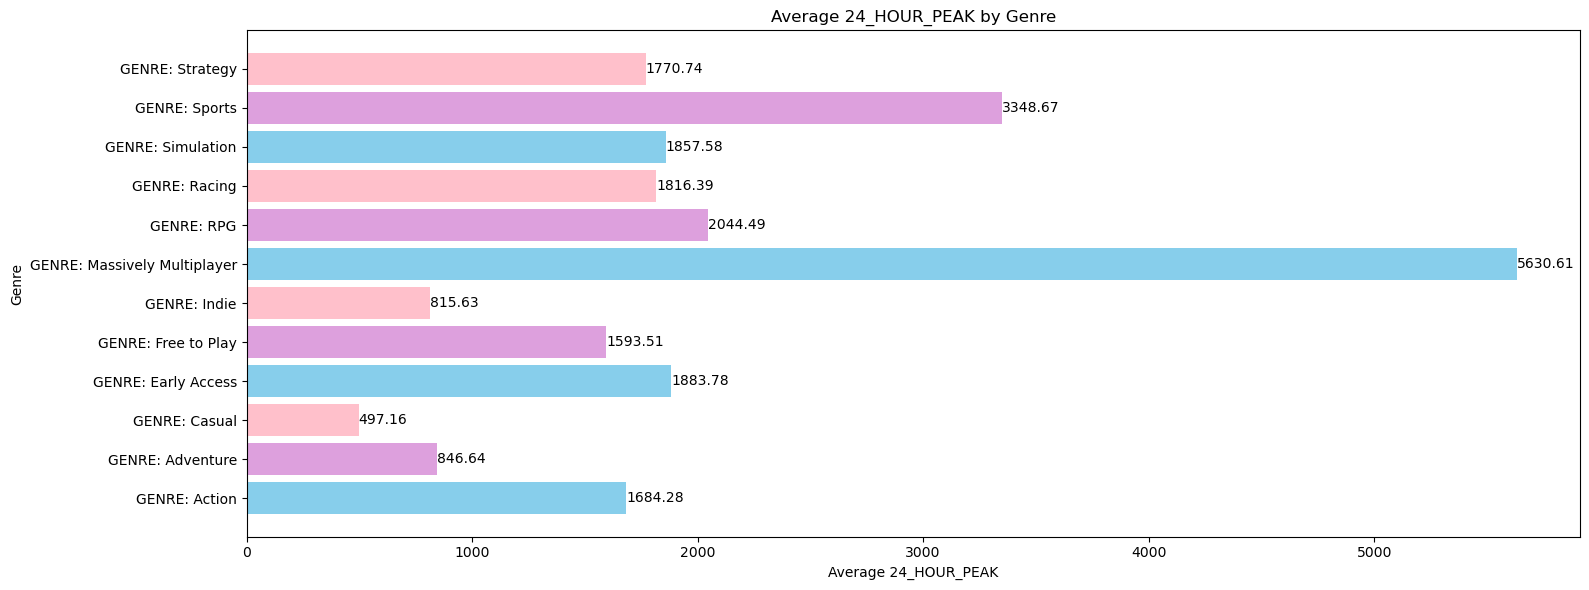

In [129]:

averages = []
for genre in genres:
    avg = df.loc[df[genre] == 1, '24_HOUR_PEAK'].mean()
    averages.append(avg)
    print(genre, avg)

colors = ['skyblue', 'plum', 'pink']

plt.figure(figsize=(16, 6))
bars = plt.barh(genres, averages, color=colors)

for bar, avg in zip(bars, averages):
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height() / 2, round(avg, 2), va='center', ha='left')

plt.title('Average 24_HOUR_PEAK by Genre')
plt.ylabel('Genre')
plt.xlabel('Average 24_HOUR_PEAK')
plt.tight_layout()
plt.show()

In [130]:
genres_counts = df[genres].sum()

genres_groups = pd.DataFrame({
    "GENRE": genres_counts.index,
    "GENRE_COUNT": genres_counts.values
})

genres_groups['24_HOUR_PEAK'] = pd.Series([df[df[idx] == 1]['24_HOUR_PEAK'].mean()  for idx in genres_counts.index])

genres_groups

GENRE  GENRE_COUNT  24_HOUR_PEAK
0                  GENRE: Action          833   1684.276110
1               GENRE: Adventure          950    846.642105
2                  GENRE: Casual          663    497.156863
3            GENRE: Early Access          168   1883.779762
4            GENRE: Free to Play          254   1593.511811
5                   GENRE: Indie         1342    815.631148
6   GENRE: Massively Multiplayer           18   5630.611111
7                     GENRE: RPG          433   2044.489607
8                  GENRE: Racing           54   1816.388889
9              GENRE: Simulation          476   1857.577731
10                 GENRE: Sports           48   3348.666667
11               GENRE: Strategy          325   1770.741538

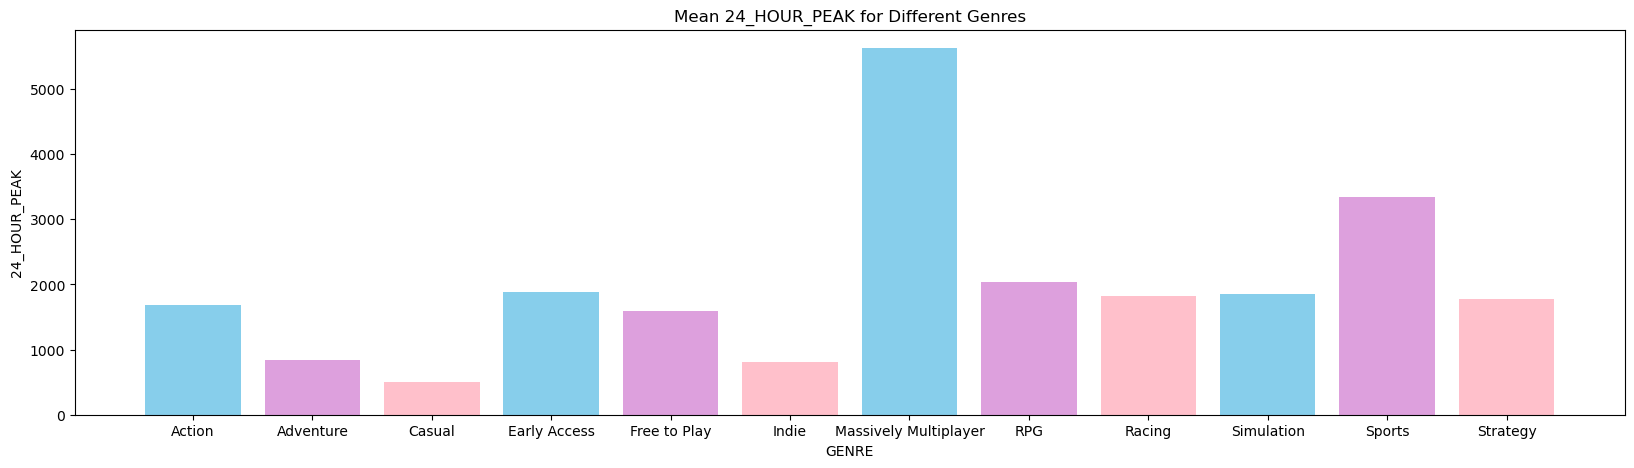

In [131]:
colors = ['skyblue', 'plum', 'pink']
metrics = ['24_HOUR_PEAK']

for metric in metrics:
    plt.figure(figsize=(20, 5))
    plt.bar(genres_groups['GENRE'].str.replace('GENRE: ', ''), genres_groups[metric], color=colors)
    plt.xlabel('GENRE')
    plt.ylabel(metric)
    plt.title(f'Mean {metric} for Different Genres')
    plt.show()

## Analyze `REVIEWS` metrics

In [132]:
df.head(1)

NAME  N_SUPPORTED_LANGUAGES  DEVELOPERS  POSITIVE_REVIEWS  \
0   470                      7         205             39271   

   NEGATIVE_REVIEWS  PRICE  24_HOUR_PEAK  PUBLISH_YEAR  RATING_SCORE  \
0              5015    NaN        1064.0          2016      0.886759   

   TOTAL_RATE_SUM  ...  GENRE: Racing  GENRE: Simulation  GENRE: Sports  \
0           44286  ...              0                  0              0   

   GENRE: Strategy  OS: Linux  OS: Windows  OS: macOS  log_24_HOUR_PEAK  \
0                0          0            1          0           6.97073   

   PRICE_CATEGORY  PLATFORM_COUNT  
0               0               1  

[1 rows x 168 columns]

In [133]:
if 'NEGATIVE_REVIEWS_percentage' not in df.columns:
    df['NEGATIVE_REVIEWS_percentage'] = df['NEGATIVE_REVIEWS']/df['TOTAL_RATE_SUM']
    numerical_features.append('NEGATIVE_REVIEWS_percentage')

reviews = ['RATING_SCORE', 'NEGATIVE_REVIEWS_percentage', 'POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'TOTAL_RATE_SUM']


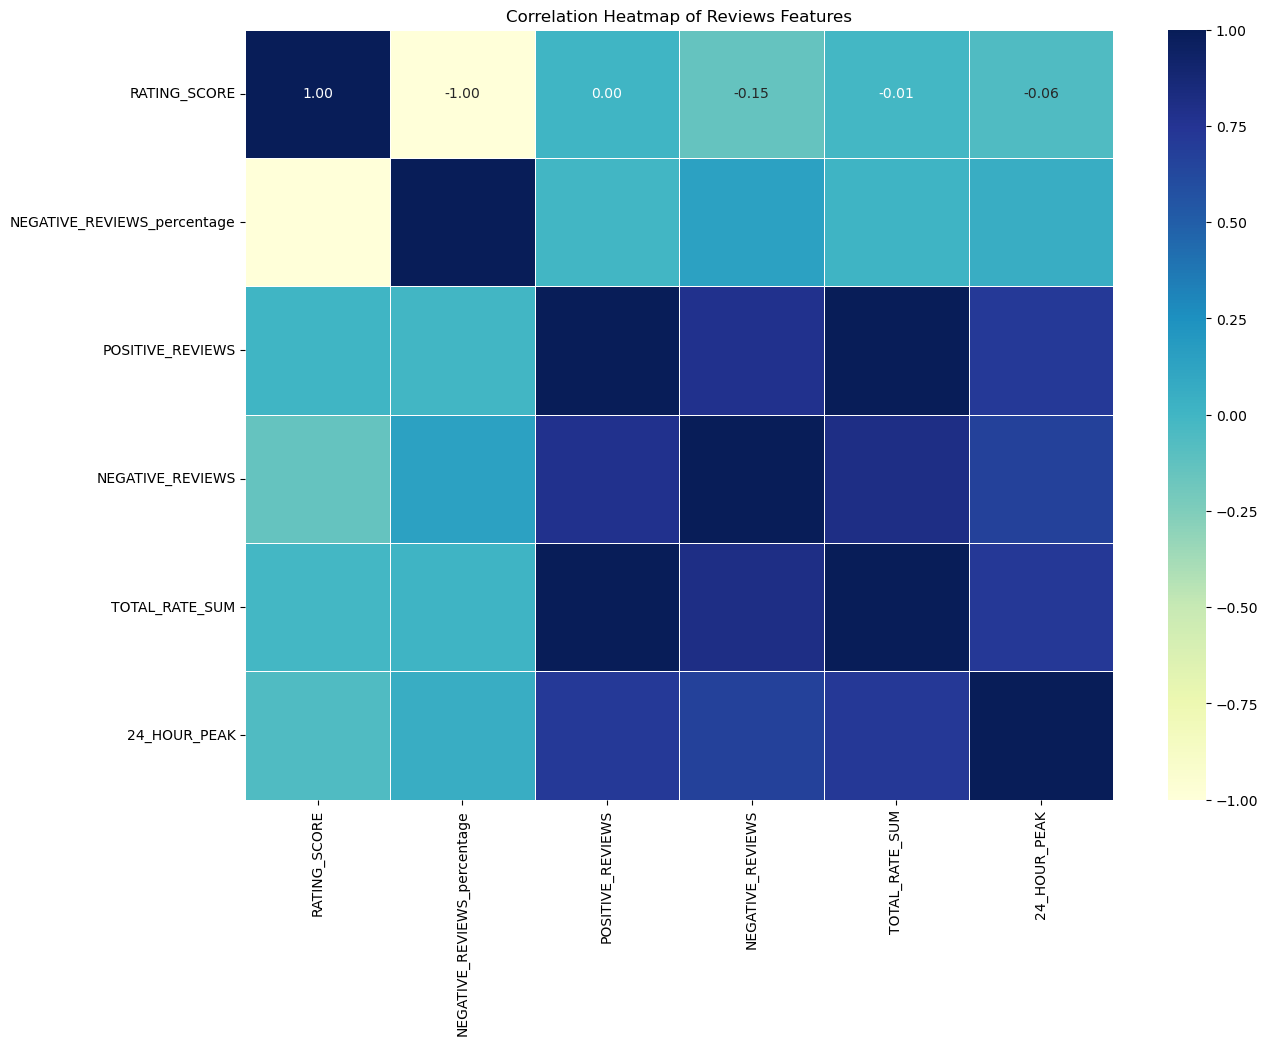

In [134]:
targets = reviews 
targets.append('24_HOUR_PEAK')



correlation_matrix = df[targets].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Reviews Features')
plt.show()

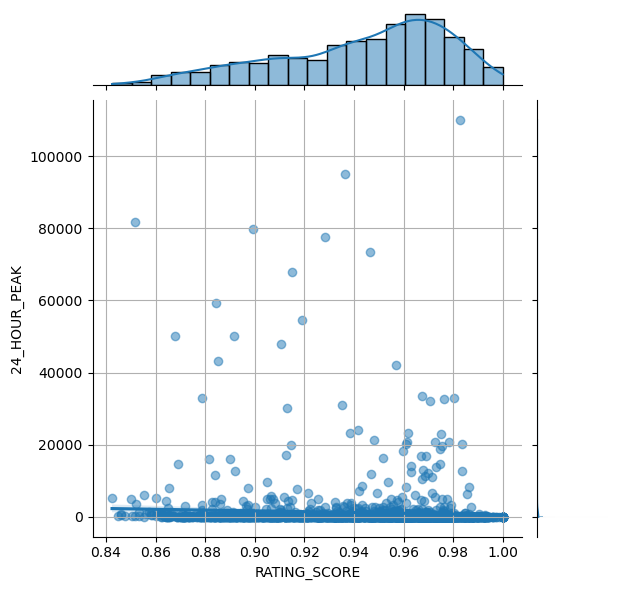

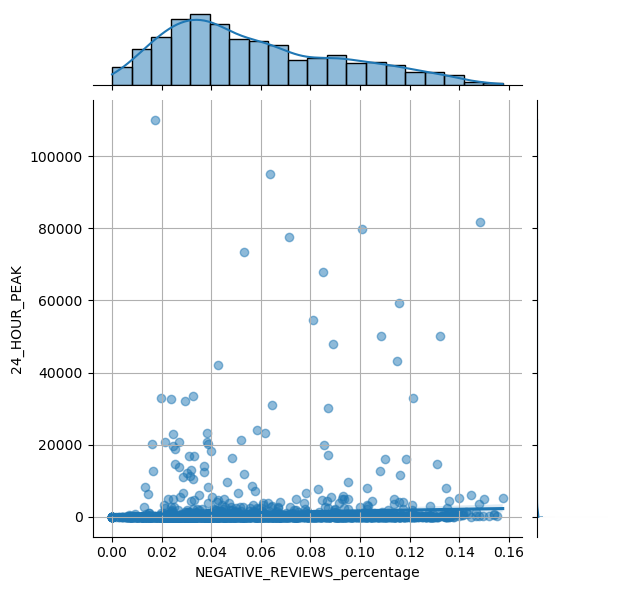

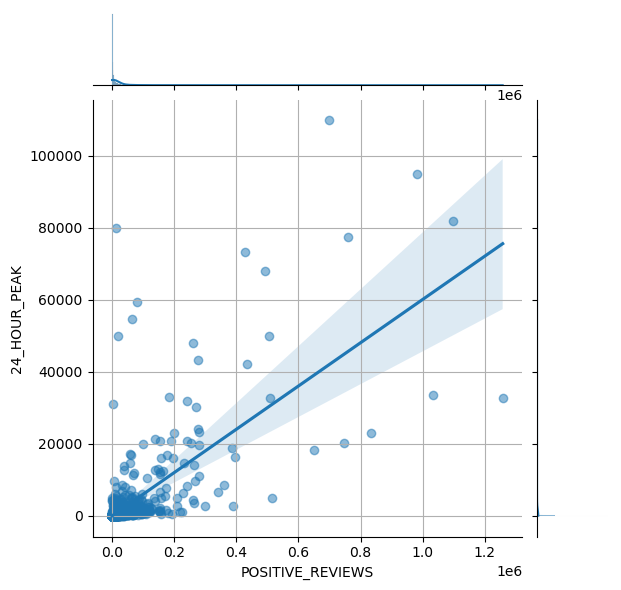

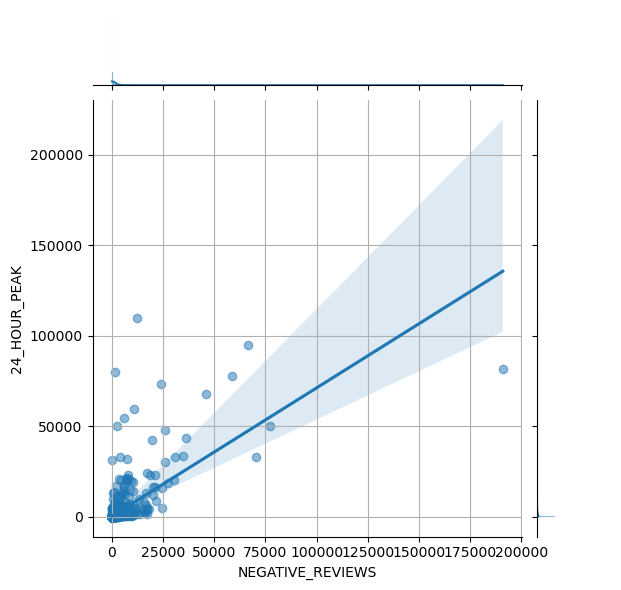

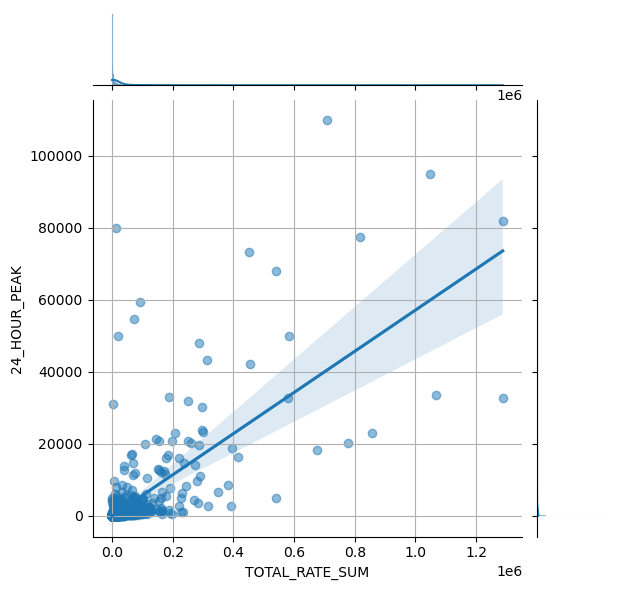

In [135]:
for metric in reviews:
    if metric == '24_HOUR_PEAK':
        continue
    sb.jointplot(x=metric, y='24_HOUR_PEAK', data=df, kind='reg', scatter_kws={'alpha':0.5})
    plt.xlabel(f'{metric}')
    plt.ylabel('24_HOUR_PEAK')
    plt.grid(True)
    plt.show()
    

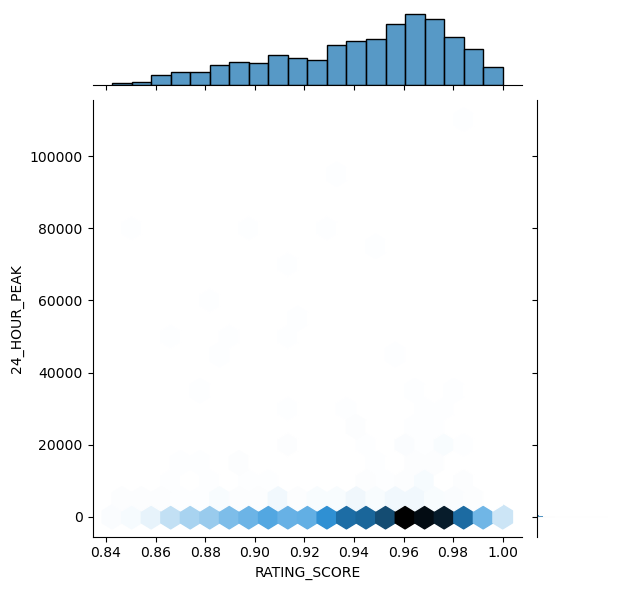

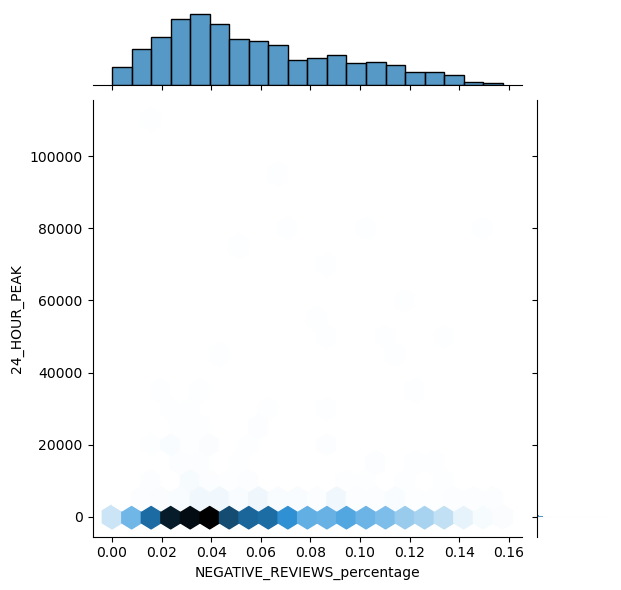

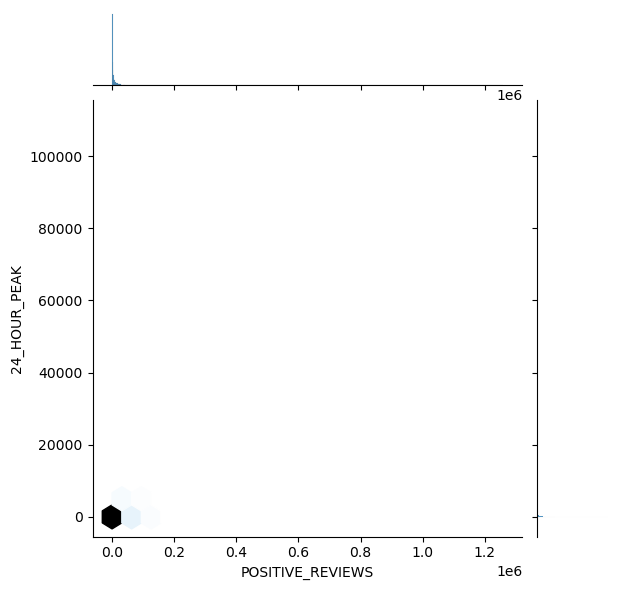

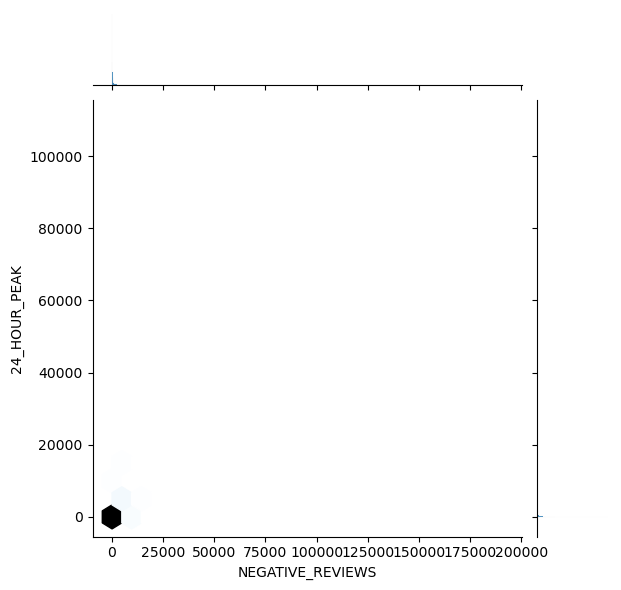

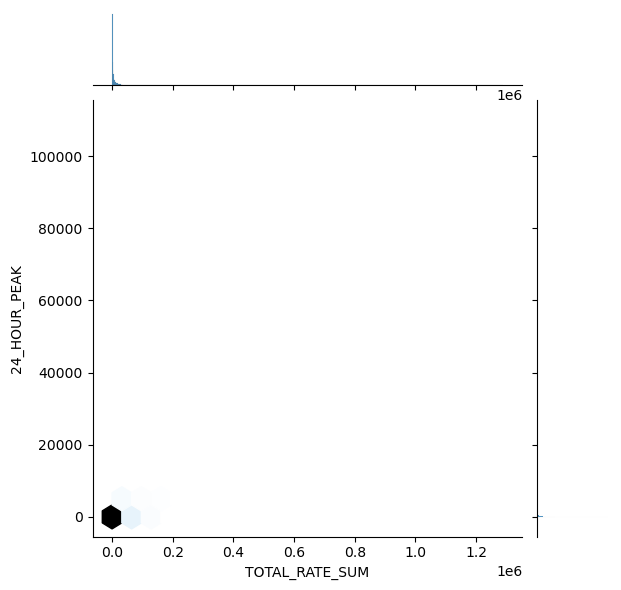

In [136]:
for metric in reviews:
    if metric == '24_HOUR_PEAK':
        continue
    sb.jointplot(x=metric, y='24_HOUR_PEAK', data=df, kind='hex', gridsize=20)
    plt.xlabel(metric)
    plt.ylabel('24_HOUR_PEAK')
    plt.show()


In [137]:
df.query("RATING_SCORE >= 0.99").sort_values(by="RATING_SCORE", ascending=False)[["NAME", "DEVELOPERS", "RATING_SCORE", "24_HOUR_PEAK"]]

NAME  DEVELOPERS  RATING_SCORE  24_HOUR_PEAK
26    1792        1080      1.000000           2.0
341    658        1610      1.000000           1.0
1967   505        1121      1.000000           1.0
1929  2009        1387      1.000000           1.0
1092   655          63      1.000000           7.0
...    ...         ...           ...           ...
1624  1161         441      0.990215          10.0
1257   793        1527      0.990202          26.0
1022   267        1374      0.990148           7.0
938    377        1429      0.990025          26.0
557    443         571      0.990000          28.0

[80 rows x 4 columns]

### Developer Analysis

In [138]:
developer_game_count = df['DEVELOPERS'].value_counts()

developer_24_HOUR_PEAK_summary = df.groupby('DEVELOPERS')['24_HOUR_PEAK'].mean().sort_values(ascending=False)

developer_summary = pd.DataFrame({
    'Game Count': developer_game_count,
    'Average 24_HOUR_PEAK': developer_24_HOUR_PEAK_summary
}).dropna().sort_values(by='Game Count', ascending=False)

developer_summary

Game Count  Average 24_HOUR_PEAK
DEVELOPERS                                  
1420                15          10115.800000
1214                14            422.357143
67                  11              2.454545
194                 10           1256.800000
1583                 7             20.714286
...                ...                   ...
681                  1              5.000000
680                  1            356.000000
679                  1           1898.000000
678                  1             14.000000
813                  1            109.000000

[1627 rows x 2 columns]

## Correlation Heatmap

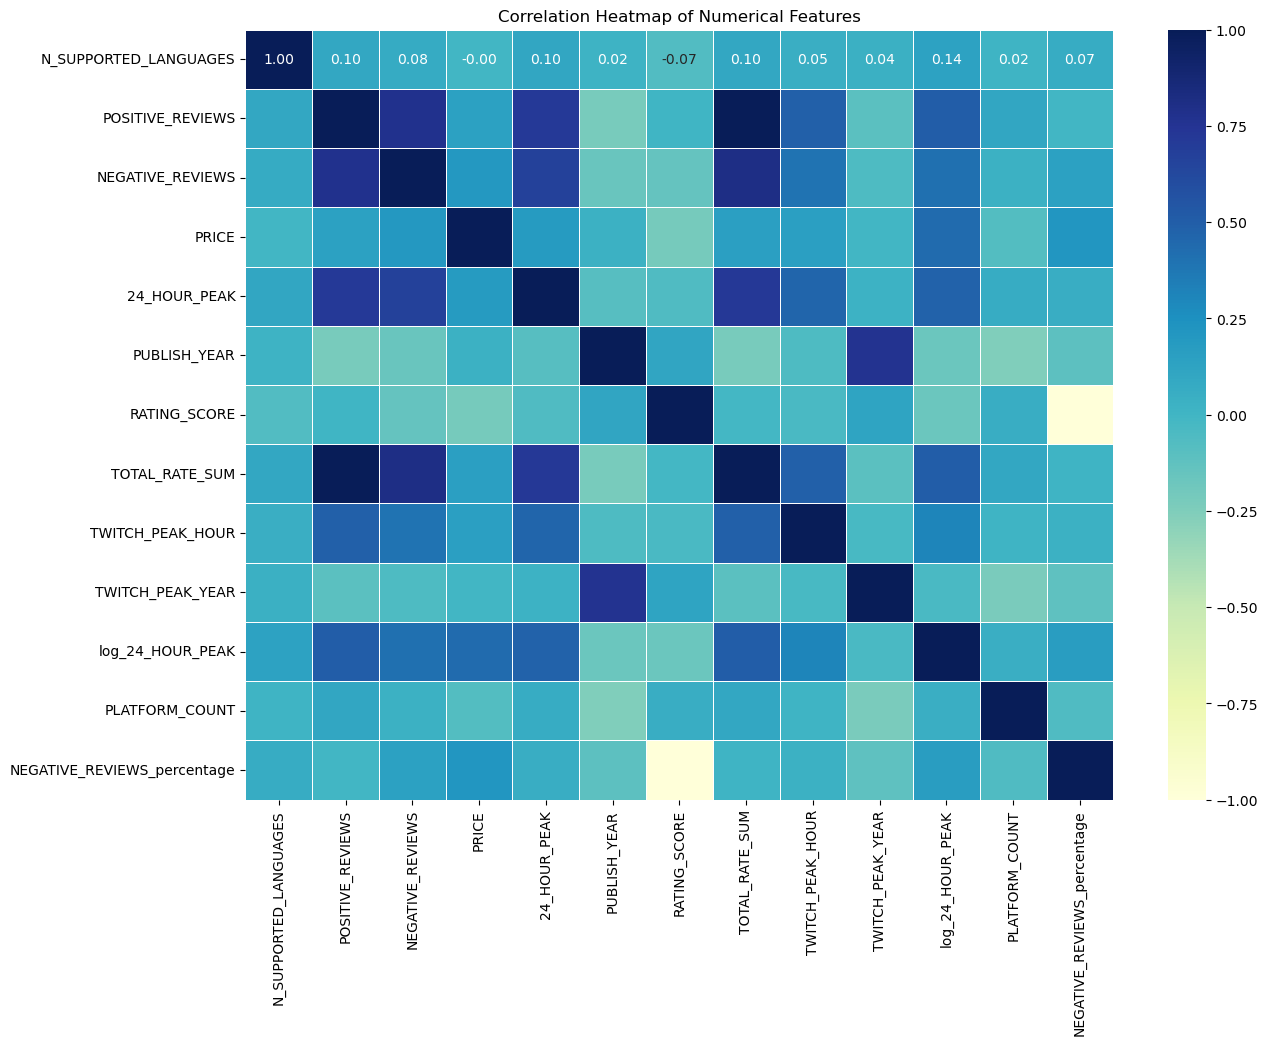

In [139]:
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

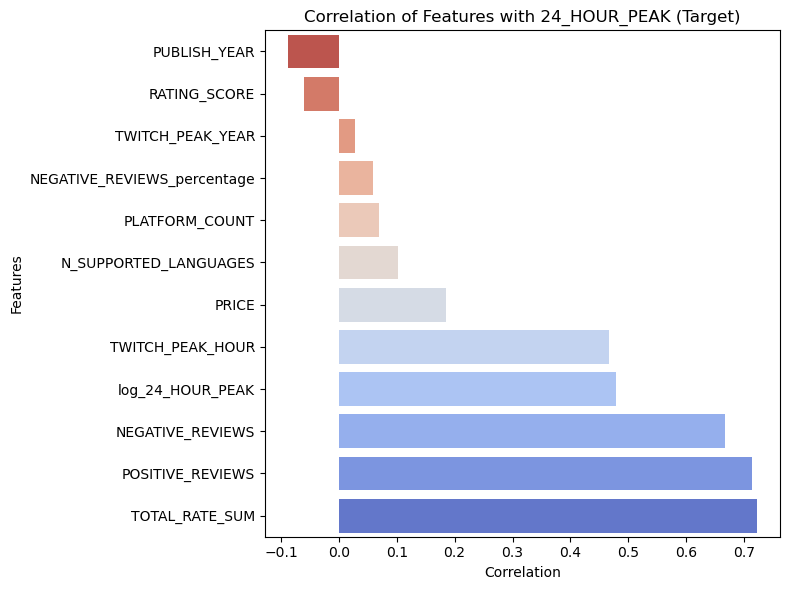

In [50]:
target_correlation = correlation_matrix['24_HOUR_PEAK'].drop('24_HOUR_PEAK').sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(y=target_correlation.index, x=target_correlation, palette='coolwarm_r', orient='h')
plt.title('Correlation of Features with 24_HOUR_PEAK (Target)')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()


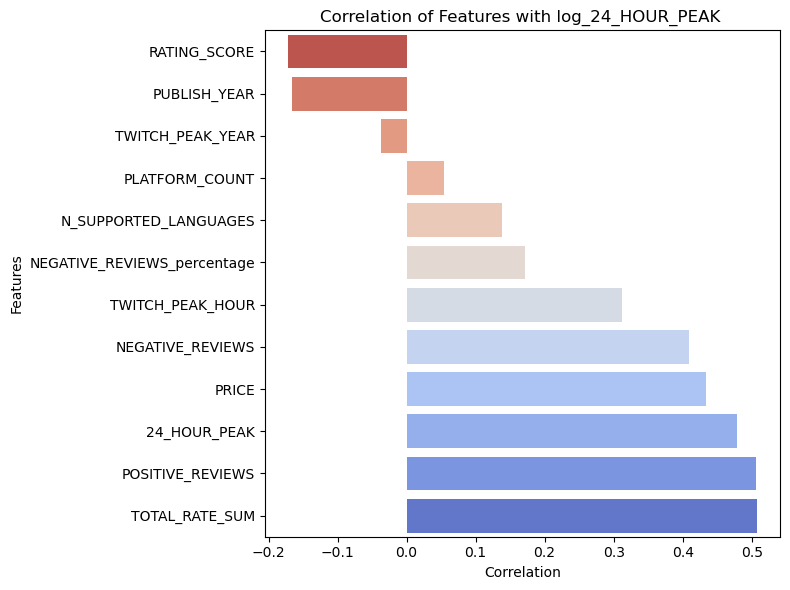

In [51]:
target_correlation = correlation_matrix['log_24_HOUR_PEAK'].drop('log_24_HOUR_PEAK').sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(y=target_correlation.index, x=target_correlation, palette='coolwarm_r', orient='h')
plt.title('Correlation of Features with log_24_HOUR_PEAK ')
plt.ylabel('Features')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()


# Evaluation Metric

Choose appropriate evaluation metrics based on the nature of the data and the project goal, and **explain your reasons for choosing them.**

In [52]:
def analysis_model(history, model, X_train, y_train, X_val, y_val, title='Model Performance'):
    if history is not None:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mean_absolute_error'], label='Train MAE')
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
        plt.title('Model Mean Absolute Error')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.show()
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
    
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
    
    metrics_df = pd.DataFrame({
        'Set': ['Training', 'Validation'],
        'Loss': [train_loss, val_loss],
        'RMSE': [train_rmse, val_rmse],
        'R-squared': [train_r2, val_r2],
        'MAE': [train_mae, val_mae]
    })
    
    print(f'{title} - Evaluation Metrics:')
    return metrics_df

In [53]:
def plot_learning_curve(estimator, X, y, title='Learning Curve', cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(14, 7))
    plt.title(title)
    
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, validation_scores_mean, 'o-', color='g', label='Cross-validation Score')
    
    plt.xlabel('Train Sizes')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def print_evaluation_metrics(model, X, y, title='Evaluation Metrics'):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    
    print(f"{title}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared: {r2}")

# Feature Selection

In [54]:
target_y = 'log_24_HOUR_PEAK'

In [55]:
if '24_HOUR_PEAK' in df.columns:
    df = df.drop(columns='24_HOUR_PEAK')
    numerical_features.remove('24_HOUR_PEAK')

In [56]:
if technologies[0] in df.columns:
    df = df.drop(columns=technologies)

In [57]:
if 'PRICE' in df.columns:    
    df = df.drop(columns = "PRICE")
    numerical_features.remove('PRICE')

In [58]:
if 'PRICE_CATEGORY' in df.columns:    
    df = df.drop(columns = "PRICE_CATEGORY")

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2032 entries, 0 to 2031
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NAME                          2032 non-null   int32  
 1   N_SUPPORTED_LANGUAGES         2032 non-null   int64  
 2   DEVELOPERS                    2032 non-null   int32  
 3   POSITIVE_REVIEWS              2032 non-null   int64  
 4   NEGATIVE_REVIEWS              2032 non-null   int64  
 5   PUBLISH_YEAR                  2032 non-null   int64  
 6   RATING_SCORE                  2032 non-null   float64
 7   TOTAL_RATE_SUM                2032 non-null   int64  
 8   TWITCH_PEAK_HOUR              2032 non-null   float64
 9   TWITCH_PEAK_YEAR              2032 non-null   int64  
 10  GENRE: Action                 2032 non-null   int64  
 11  GENRE: Adventure              2032 non-null   int64  
 12  GENRE: Casual                 2032 non-null   int64  
 13  GEN

**Remove highly correlated features (correlation coefficient > 0.9)**

In [60]:
correlation_matrix = df[numerical_features].corr()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
print(high_correlation)
df = df.drop(columns=high_correlation)
df_reduced = df

['TOTAL_RATE_SUM']


**SelectKBest to select top features based on f_regression**

In [61]:
# Temporary testing code - not used in final implementation
X = df_reduced.drop(target_y, axis=1)
y = df_reduced[target_y]
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")


Selected features: Index(['POSITIVE_REVIEWS', 'NEGATIVE_REVIEWS', 'PUBLISH_YEAR', 'RATING_SCORE',
       'TWITCH_PEAK_HOUR', 'GENRE: Casual', 'GENRE: Indie',
       'GENRE: Simulation', 'GENRE: Strategy', 'NEGATIVE_REVIEWS_percentage'],
      dtype='object')


In [62]:
df_selected = df_reduced[selected_features].copy()
df_selected[target_y] = y

## Split the dataset into training and testing sets (`df_selected`)

In [63]:
X_train_selected, X_test_selected, y_train, y_test = train_test_split(df_selected.drop(target_y, axis=1), df_selected[target_y], test_size=0.2, random_state=42)

## Standardization (`df_selected`)

In [64]:
scaler = StandardScaler()

X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

## Create the XGBoost regressor object

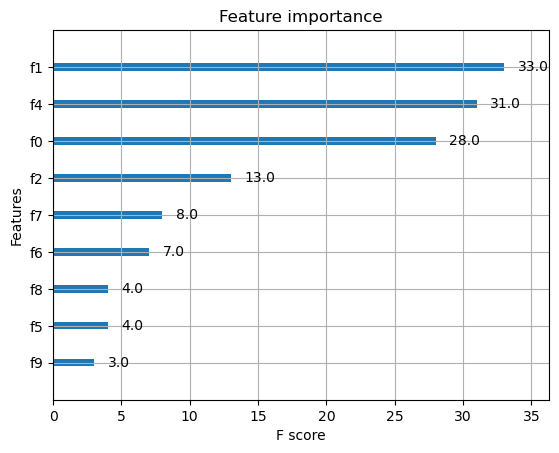

In [65]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train_selected_scaled, y_train)

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12, 9]
plt.show()

## Testing Our Features

In [66]:
model = Sequential([
    Input(shape=(X_train_selected_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(Adam(learning_rate=.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train_selected_scaled, y_train, epochs=60, batch_size=16, shuffle=True, validation_split=0.2)

Epoch 1/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 12.6358 - mean_absolute_error: 2.8040 - val_loss: 8.8323 - val_mean_absolute_error: 1.6661
Epoch 2/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7540 - mean_absolute_error: 1.5335 - val_loss: 9.3442 - val_mean_absolute_error: 1.6185
Epoch 3/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4688 - mean_absolute_error: 1.4591 - val_loss: 8.4703 - val_mean_absolute_error: 1.5734
Epoch 4/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0397 - mean_absolute_error: 1.4113 - val_loss: 12.2667 - val_mean_absolute_error: 1.6191
Epoch 5/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1219 - mean_absolute_error: 1.4074 - val_loss: 12.8040 - val_mean_absolute_error: 1.5972
Epoch 6/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8682 - mean_absolute_error: 1.3463 - val_loss: 13.2606 - val_mean_absolute_error: 1.5838
Epoch 7/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7963 - mean_absolute_error: 1.3306 - val_loss: 1

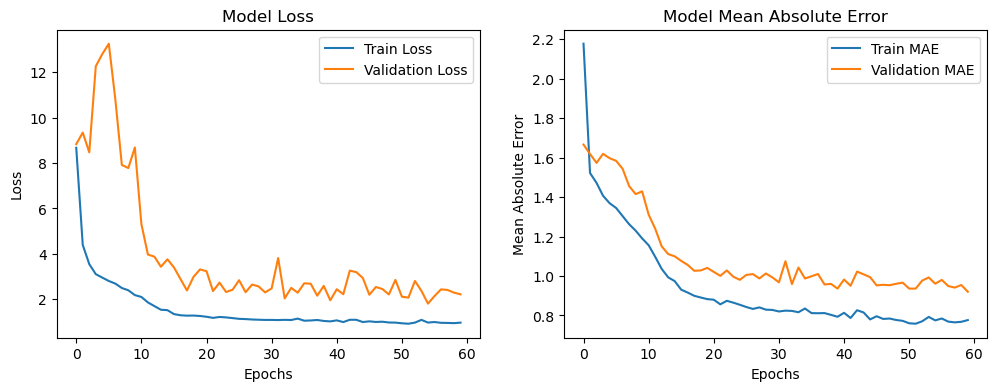

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step
Model Performance - Evaluation Metrics:


Set      Loss      RMSE  R-squared       MAE
0    Training  1.118154  1.040671   0.775766  0.773983
1  Validation  1.535291  1.242543   0.670806  0.968251

In [67]:
# Evaluate the model

analysis_model(history, model, X_train_selected_scaled, y_train, X_test_selected_scaled, y_test)

# Split the dataset into training and testing sets (`df`)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target_y, axis=1), df_selected[target_y], test_size=0.2, random_state=42)

# Standardization (`df`)

In [69]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction

Using the PCA method, reduce the dimensions of numerical features to two dimensions. 


How much of the initial data variance is transferred to the new space?

If we aim to retain 95% of the original variance, what is the minimum number of dimensions 
required in the new space  Save both the original data and the dimension-reduced one fo 
the next parts.

In [70]:
pca_95 = PCA(n_components=0.95)
X_train_pca_95 = pca_95.fit_transform(X_train_scaled)
X_test_pca_95 = pca_95.transform(X_test_scaled)
print(f"Number of components to retain 95% variance: {pca_95.n_components_}")

Number of components to retain 95% variance: 20


In [71]:
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)
print(f"2 components retain {pca_2d.noise_variance_ * 100}% variance")

2 components retain 81.33448165430707% variance


In [72]:
X_train_pca_2d

array([[ 2.46482897, -1.87141324],
       [ 1.2458453 ,  0.20961396],
       [-1.40536703, -0.78068797],
       ...,
       [-0.84993431, -0.4593105 ],
       [-1.6793509 , -1.38079093],
       [ 4.61299584,  2.10094213]])

# Model Training

In this section, you need to implement three methods to predict your target variable.   
First, split the initial data (including all features) into training and test sets.

## Method One:  Neural Network

In [155]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='relu')
])

model.compile(Adam(learning_rate=.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train_scaled, y_train, epochs=60, batch_size=16, shuffle=True, validation_split=0.2)

Epoch 1/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.7213 - mean_absolute_error: 3.1002 - val_loss: 5.0322 - val_mean_absolute_error: 1.6062
Epoch 2/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5643 - mean_absolute_error: 1.6372 - val_loss: 5.3974 - val_mean_absolute_error: 1.4996
Epoch 3/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8703 - mean_absolute_error: 1.5232 - val_loss: 6.3672 - val_mean_absolute_error: 1.4912
Epoch 4/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7304 - mean_absolute_error: 1.2877 - val_loss: 7.2199 - val_mean_absolute_error: 1.4933
Epoch 5/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8133 - mean_absolute_error: 1.3285 - val_loss: 7.1695 - val_mean_absolute_error: 1.4683
Epoch 6/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5140 - mean_absolute_error: 1.2492 - val_loss: 7.5741 - val_mean_absolute_error: 1.4694
Epoch 7/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1529 - mean_absolute_error: 1.1595 - val_loss: 7.42

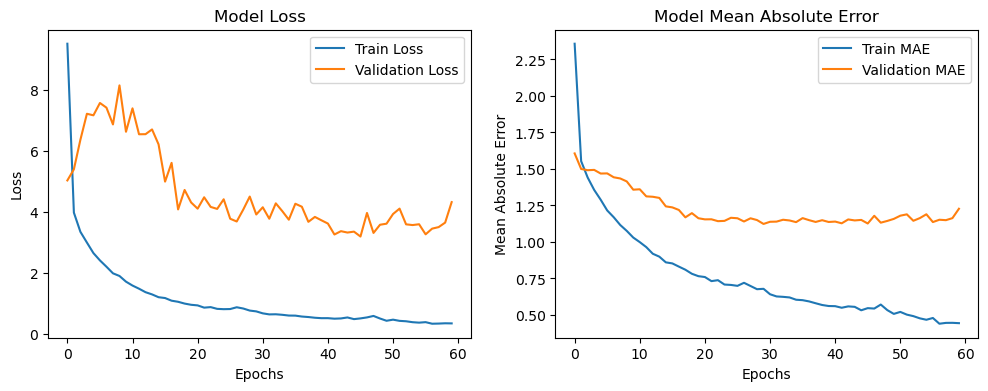

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Model Performance - Evaluation Metrics:


Set      Loss      RMSE  R-squared       MAE
0    Training  1.217586  1.052511   0.770634  0.615379
1  Validation  2.183037  1.482897   0.531131  1.176697

In [156]:
# Evaluate the model
analysis_model(history, model, X_train_scaled, y_train , X_test_scaled, y_test)

In [75]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Linear activation for regression
])

model.compile(Adam(learning_rate=.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train_scaled, y_train, epochs=60, batch_size=16, shuffle=True, validation_split=0.2)

Epoch 1/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 22.3514 - mean_absolute_error: 3.9525 - val_loss: 15.2924 - val_mean_absolute_error: 3.1214
Epoch 2/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.2000 - mean_absolute_error: 3.2826 - val_loss: 9.8231 - val_mean_absolute_error: 2.4175
Epoch 3/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.7229 - mean_absolute_error: 2.6966 - val_loss: 6.9262 - val_mean_absolute_error: 1.9155
Epoch 4/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0173 - mean_absolute_error: 2.0937 - val_loss: 5.6193 - val_mean_absolute_error: 1.5939
Epoch 5/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7856 - mean_absolute_error: 1.7076 - val_loss: 5.4351 - val_mean_absolute_error: 1.4688
Epoch 6/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4467 - mean_absolute_error: 1.6439 - val_loss: 5.5879 - val_mean_absolute_error: 1.4349
Epoch 7/60
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3316 - mean_absolute_error: 1.6297 - val_loss: 5

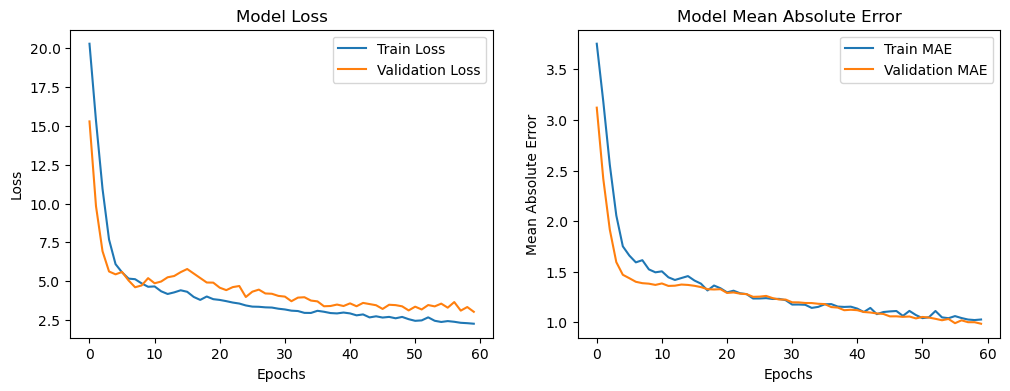

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Model Performance - Evaluation Metrics:


Set      Loss      RMSE  R-squared       MAE
0    Training  1.969014  1.162526   0.720179  0.849738
1  Validation  2.392664  1.351710   0.610420  1.034928

In [76]:
# Evaluate the model
analysis_model(history, model, X_train_scaled, y_train , X_test_scaled, y_test)

In [77]:
table_cols = ['# of units per layer', '# of epochs', 'Size of batches']
table2 = pd.DataFrame(columns = table_cols)

param_sets = [[16,32,64],[256,200,16],[16,200,16],[16,128,16]]

for ps in param_sets:
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(rate=0.4),
        Dense(ps[0], activation='relu'),
        Dense(1, activation='relu')
    ])

    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=.001))


   
    train_start = dt.datetime.now()
    history = model.fit(X_train_scaled, y_train, epochs=ps[1], batch_size=ps[2], verbose=0, validation_split=0.1)

    train_end = dt.datetime.now()
    train_duration = (train_end - train_start).total_seconds()
    
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Compute RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Compute R-squared (R2)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Compute MAE
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    # Compute loss (mean squared error as a proxy for loss)
    loss_train = mean_squared_error(y_train, y_train_pred)
    loss_test = mean_squared_error(y_test, y_test_pred)
    
    run = pd.DataFrame({
        '# of units per layer': [ps[0]],
        '# of epochs': [ps[1]],
        'Size of batches': [ps[2]],
        'Training time': [train_duration],
        'Loss (Train)': [loss_train],
        'Loss (TEST)': [loss_test],
        'RMSE (Train)': [rmse_train],
        'RMSE (TEST)': [rmse_test],
        'R2 (Train)': [r2_train],
        'R2 (TEST)': [r2_test],
        'MAE (Train)': [mae_train],
        'MAE (TEST)': [mae_test]
    })
    
    
    table2 = pd.concat([table2, run], ignore_index=True)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step


In [78]:
# results:
table2

# of units per layer # of epochs Size of batches  Training time  \
0                   16          32              64       3.741940   
1                  256         200              16      28.986325   
2                   16         200              16      26.987884   
3                   16         128              16      16.896468   

   Loss (Train)  Loss (TEST)  RMSE (Train)  RMSE (TEST)  R2 (Train)  \
0      2.549694     3.018758      1.596776     1.737457    0.472086   
1      0.554259     1.680379      0.744485     1.296294    0.885241   
2      0.658522     1.493838      0.811493     1.222227    0.863653   
3      0.908914     1.555800      0.953370     1.247317    0.811809   

   R2 (TEST)  MAE (Train)  MAE (TEST)  
0   0.356338     1.061174    1.258086  
1   0.641708     0.460525    1.034333  
2   0.681483     0.579325    0.962577  
3   0.668271     0.630648    0.951122

## Methods Two: Decision Tree Regressor

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}


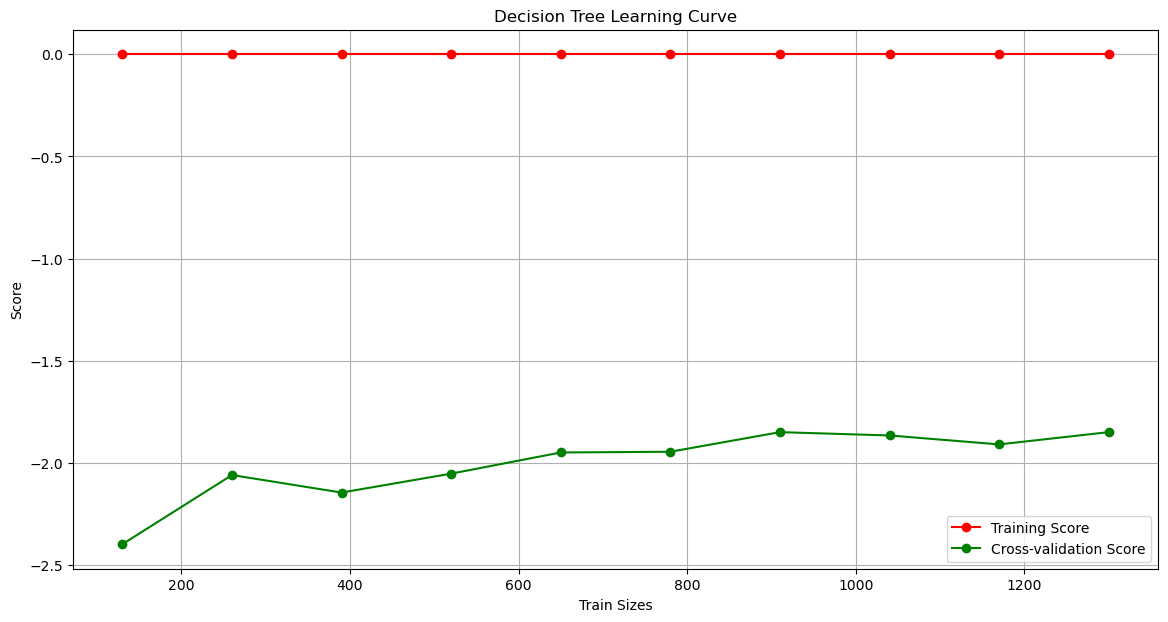

Decision Tree:
Mean Absolute Error (MAE): 0.6147685820377253
Root Mean Squared Error (RMSE): 0.7949319740380001
R-squared: 0.8691616072733632
********************************************************************************
Decision Tree (TEST):
Mean Absolute Error (MAE): 0.8455609439947211
Root Mean Squared Error (RMSE): 1.1141953095109933
R-squared: 0.735301000398328


In [79]:
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10]
}

dt_model = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Best estimator
best_dt_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

plot_learning_curve(dt_model, X_train_scaled, y_train, title='Decision Tree Learning Curve')
print_evaluation_metrics(best_dt_model, X_train_scaled, y_train, title='Decision Tree')
print("**" * 40)
print_evaluation_metrics(best_dt_model, X_test_scaled, y_test, title='Decision Tree (TEST)')

## Methods Three: Support Vector Machine Regressor

Fitting 5 folds for each of 126 candidates, totalling 630 fits
Best parameters found:  {'C': 0.05, 'epsilon': 0.02, 'kernel': 'sigmoid'}


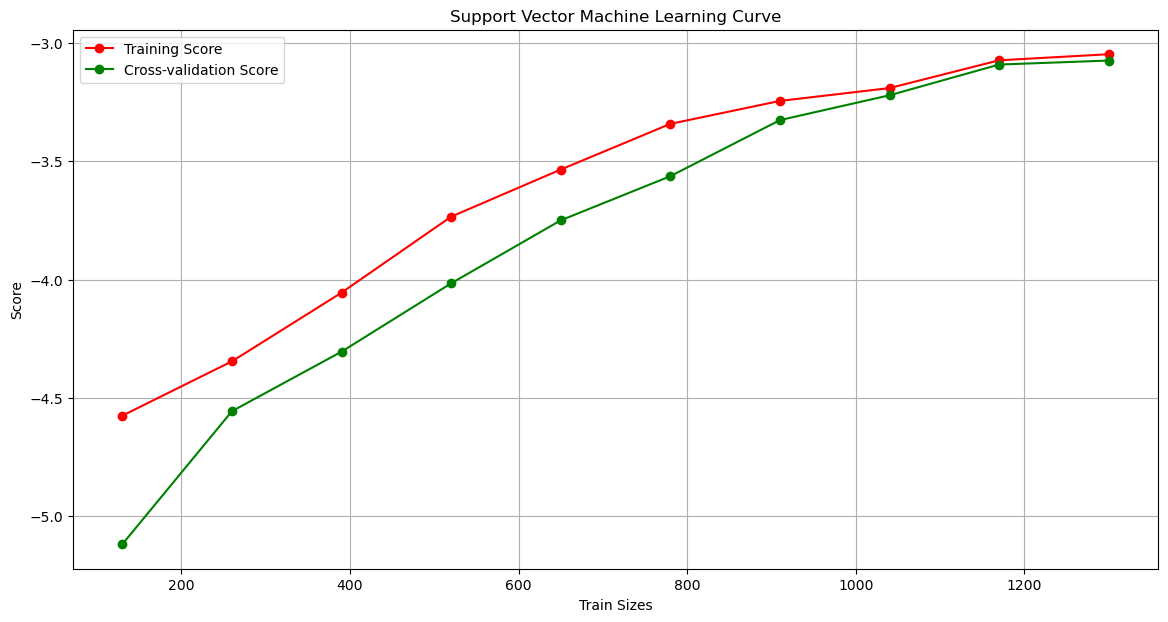

Support Vector Machine:
Mean Absolute Error (MAE): 1.3956271070033301
Root Mean Squared Error (RMSE): 1.744185869877018
R-squared: 0.37011568096456693
********************************************************************************
Support Vector Machine (TEST):
Mean Absolute Error (MAE): 1.424771084435031
Root Mean Squared Error (RMSE): 1.766725135936086
R-squared: 0.33447001946996047


In [80]:
param_grid = {
    'kernel': ['linear', 'poly', 'sigmoid'],
    'C': [0.001, 0.01, 0.05, 0.1, 0.5, 0.9, 1],
    'epsilon': [0.01, 0.015, 0.02, 0.05, 0.1, 1]
}

svm_model = SVR()
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error',  verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Best estimator
best_svm_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

plot_learning_curve(best_svm_model, X_train_scaled, y_train, title='Support Vector Machine Learning Curve')
print_evaluation_metrics(best_svm_model, X_train_scaled, y_train, title='Support Vector Machine')
print("**" * 40)
print_evaluation_metrics(best_svm_model, X_test_scaled, y_test, title='Support Vector Machine (TEST)')

## Methods Four: Linear Regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters found:  {'copy_X': True, 'fit_intercept': True}


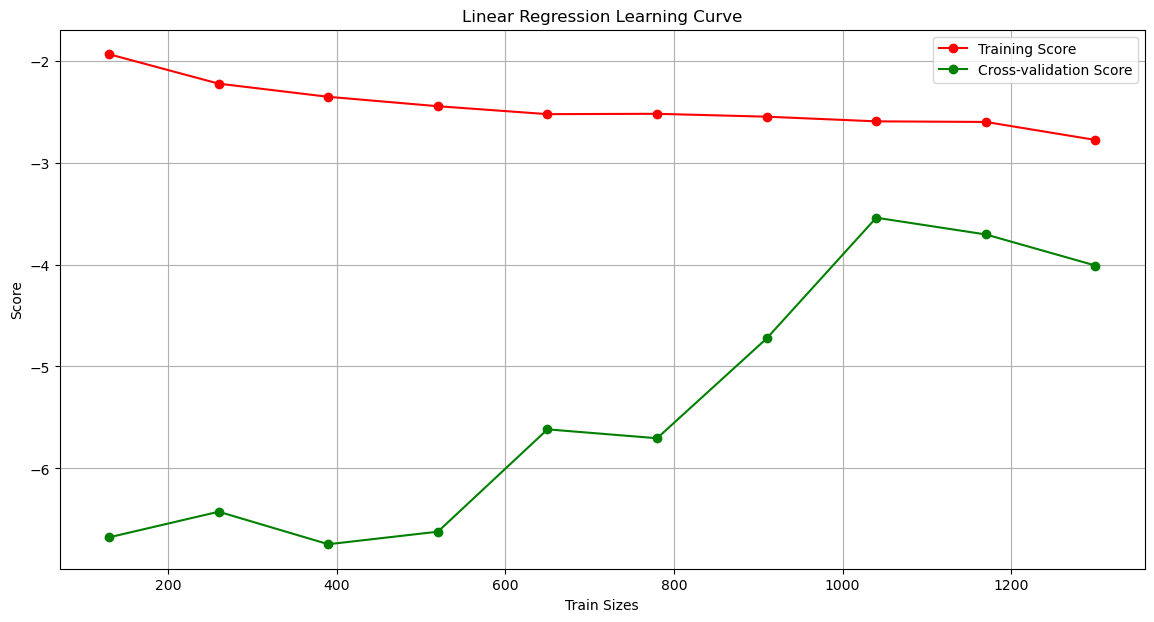

Linear Regression (Training):
Mean Absolute Error (MAE): 1.3431794781023956
Root Mean Squared Error (RMSE): 1.681415033516217
R-squared: 0.41463719745009053
********************************************************************************
Linear Regression (TEST):
Mean Absolute Error (MAE): 1.3606837568204557
Root Mean Squared Error (RMSE): 1.6960694969679437
R-squared: 0.3866379023522314


In [81]:
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

lr_model = LinearRegression()
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Best estimator
best_lr_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

plot_learning_curve(best_lr_model, X_train_scaled, y_train, title='Linear Regression Learning Curve')
print_evaluation_metrics(best_lr_model, X_train_scaled, y_train, title='Linear Regression (Training)')
print("**" * 40)
print_evaluation_metrics(best_lr_model, X_test_scaled, y_test, title='Linear Regression (TEST)')

## Methods Five: KNN

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'n_neighbors': 7, 'p': 1}


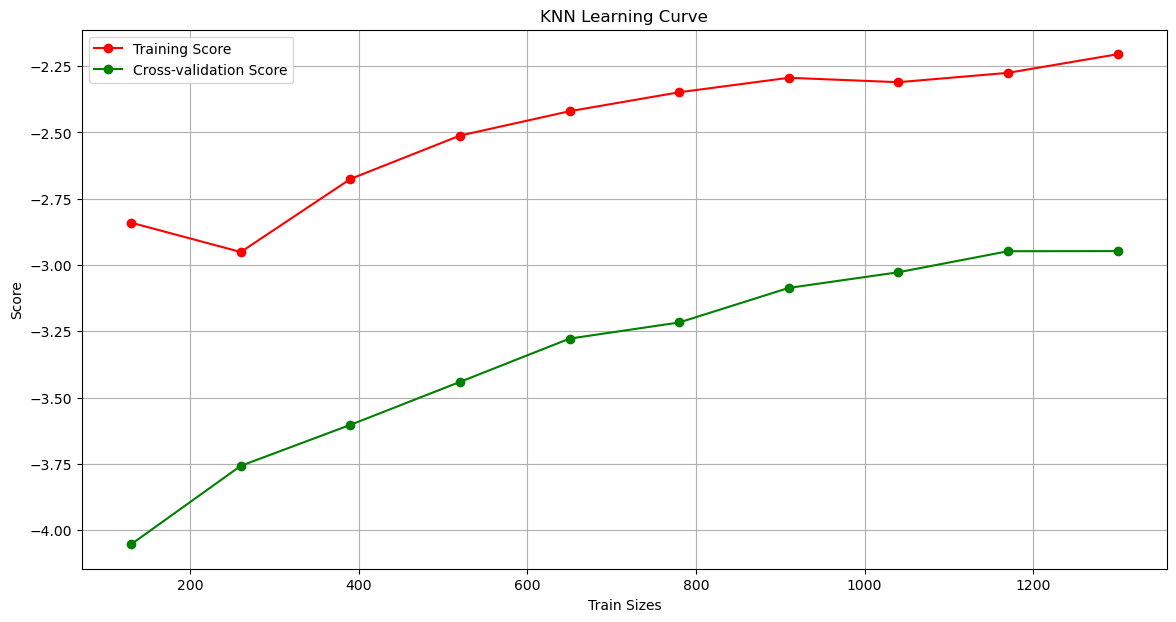

KNN (Training):
Mean Absolute Error (MAE): 1.1198805226699178
Root Mean Squared Error (RMSE): 1.4586889559884466
R-squared: 0.5594444682492764
********************************************************************************
KNN (TEST):
Mean Absolute Error (MAE): 1.3721145616269976
Root Mean Squared Error (RMSE): 1.753059870304279
R-squared: 0.3447256853450662


In [82]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

knn_model = KNeighborsRegressor()

grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=3)
grid_search.fit(X_train_scaled, y_train)

# Best estimator
best_knn_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

plot_learning_curve(best_knn_model, X_train_scaled, y_train, title='KNN Learning Curve')
print_evaluation_metrics(best_knn_model, X_train_scaled, y_train, title='KNN (Training)')
print("**" * 40)
print_evaluation_metrics(best_knn_model, X_test_scaled, y_test, title='KNN (TEST)')

## Methods Six: XGBoost

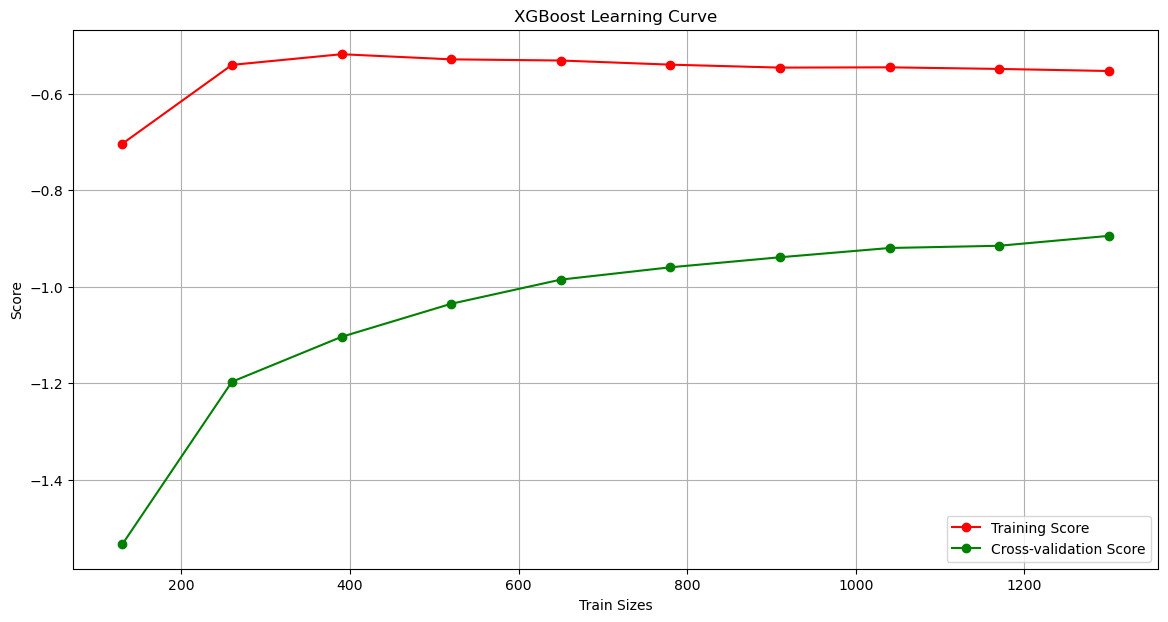

XGBoost (Training):
Mean Absolute Error (MAE): 0.5860730929603588
Root Mean Squared Error (RMSE): 0.7496485854850025
R-squared: 0.8836434808238242
********************************************************************************
XGBoost (TEST):
Mean Absolute Error (MAE): 0.7428412842719543
Root Mean Squared Error (RMSE): 0.9654529669740577
R-squared: 0.8012569770531637


In [145]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 5, alpha = 10, n_estimators = 1000)

xg_reg.fit(X_train_scaled, y_train)

plot_learning_curve(xg_reg, X_train_scaled, y_train, title='XGBoost Learning Curve')
print_evaluation_metrics(xg_reg, X_train_scaled, y_train, title='XGBoost (Training)')
print("**" * 40)
print_evaluation_metrics(xg_reg, X_test_scaled, y_test, title='XGBoost (TEST)')

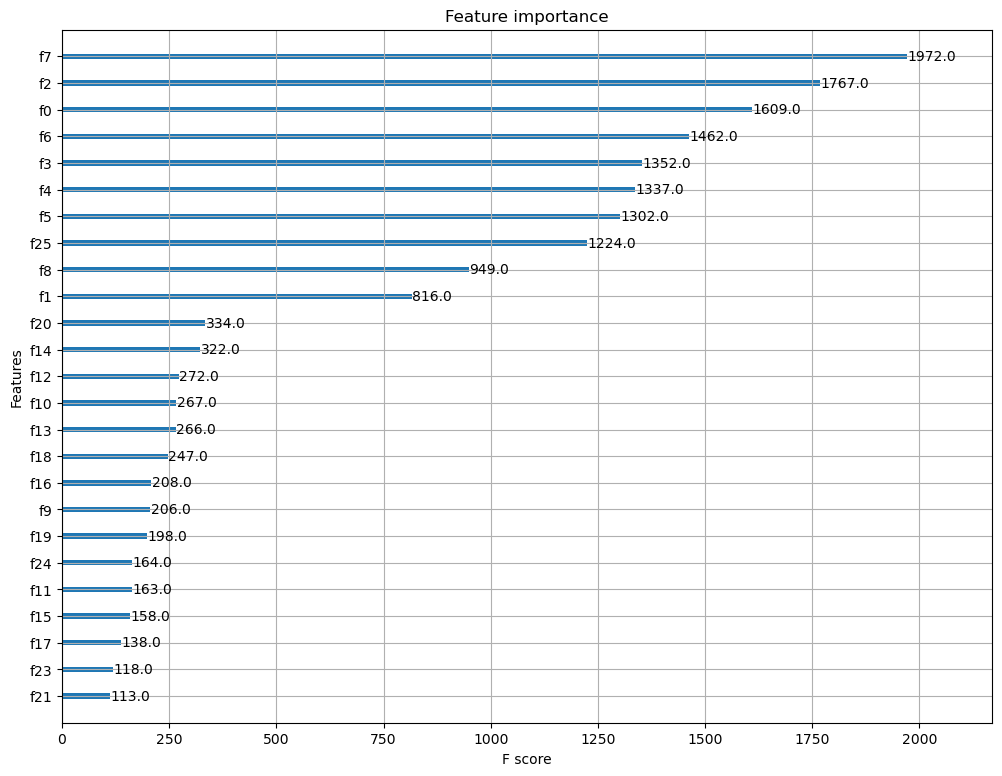

In [146]:

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12, 9]
plt.show()

# Feature Analysis

Train the best-performing method from the previous section using the dimension-reduced data. 
**How did the model performance change? Provide your analysis.**

## `PCA_95`

### Neural Network: (`PCA_95`)

In [84]:
table_cols = ['# of units per layer', '# of epochs', 'Size of batches']
table2 = pd.DataFrame(columns = table_cols)

param_sets = [[16,32,64],[256,200,16],[16,200,16],[16,128,16]]

for ps in param_sets:
    model = Sequential([
        Input(shape=(X_train_pca_95.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(rate=0.4),
        Dense(ps[0], activation='relu'),
        Dense(1, activation='relu')
    ])

    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=.001))


   
    train_start = dt.datetime.now()
    history = model.fit(X_train_pca_95, y_train, epochs=ps[1], batch_size=ps[2], verbose=0, validation_split=0.1)

    train_end = dt.datetime.now()
    train_duration = (train_end - train_start).total_seconds()
    
    y_train_pred = model.predict(X_train_pca_95)
    y_test_pred = model.predict(X_test_pca_95)
    
    # Compute RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Compute R-squared (R2)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Compute MAE
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    # Compute loss (mean squared error as a proxy for loss)
    loss_train = mean_squared_error(y_train, y_train_pred)
    loss_test = mean_squared_error(y_test, y_test_pred)
    
    run = pd.DataFrame({
        '# of units per layer': [ps[0]],
        '# of epochs': [ps[1]],
        'Size of batches': [ps[2]],
        'Training time': [train_duration],
        'Loss (Train)': [loss_train],
        'Loss (TEST)': [loss_test],
        'RMSE (Train)': [rmse_train],
        'RMSE (TEST)': [rmse_test],
        'R2 (Train)': [r2_train],
        'R2 (TEST)': [r2_test],
        'MAE (Train)': [mae_train],
        'MAE (TEST)': [mae_test]
    })
    
    table2 = pd.concat([table2, run], ignore_index=True)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


In [85]:
# results:
table2

# of units per layer # of epochs Size of batches  Training time  \
0                   16          32              64       3.643546   
1                  256         200              16      29.174867   
2                   16         200              16      26.729690   
3                   16         128              16      17.475826   

   Loss (Train)  Loss (TEST)  RMSE (Train)  RMSE (TEST)  R2 (Train)  \
0      3.110680     3.509193      1.763712     1.873284    0.355934   
1      0.875590     1.856288      0.935730     1.362456    0.818709   
2      0.940843     1.778513      0.969970     1.333609    0.805199   
3      0.935510     1.936591      0.967218     1.391615    0.806303   

   R2 (TEST)  MAE (Train)  MAE (TEST)  
0   0.251767     1.144121    1.350002  
1   0.604201     0.524072    1.083147  
2   0.620784     0.660116    1.047676  
3   0.587078     0.712915    1.013782

###  XGBoost: (`PCA_95`)

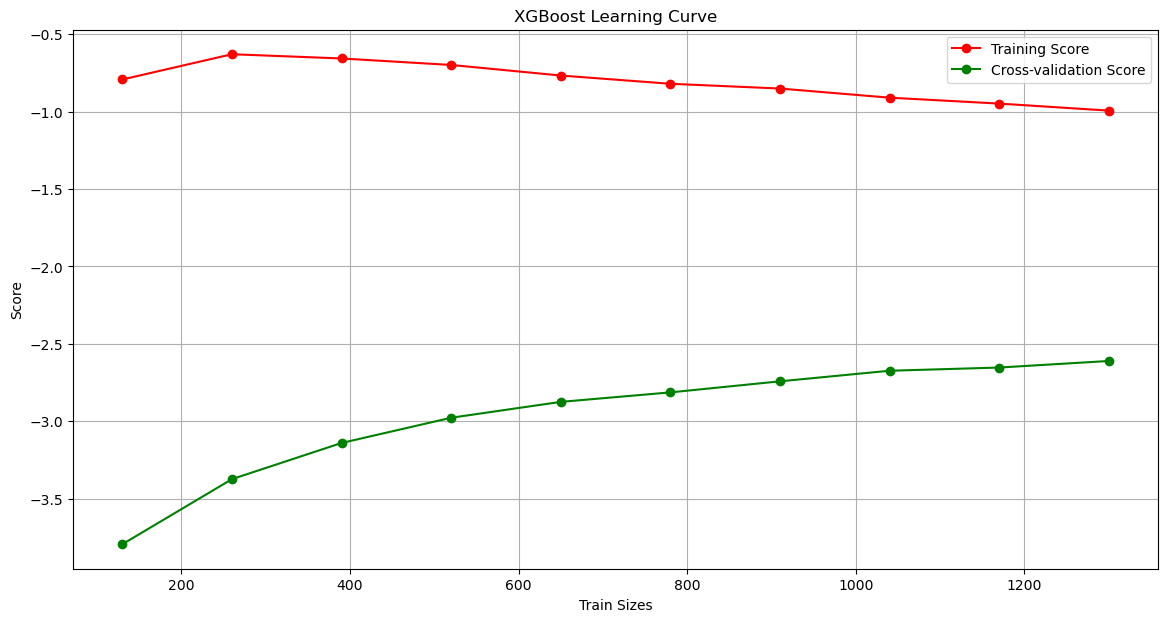

XGBoost (Training):
Mean Absolute Error (MAE): 0.8277082735326102
Root Mean Squared Error (RMSE): 1.0373939837236694
R-squared: 0.7771756136897428
********************************************************************************
XGBoost (TEST):
Mean Absolute Error (MAE): 1.300783071858265
Root Mean Squared Error (RMSE): 1.634452765069035
R-squared: 0.4303942081830755


In [166]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, 
                max_depth = 5, alpha = 10, n_estimators = 1000)

xg_reg.fit(X_train_pca_95, y_train)

plot_learning_curve(xg_reg, X_train_pca_95, y_train, title='XGBoost Learning Curve')
print_evaluation_metrics(xg_reg, X_train_pca_95, y_train, title='XGBoost (Training)')
print("**" * 40)
print_evaluation_metrics(xg_reg, X_test_pca_95, y_test, title='XGBoost (TEST)')

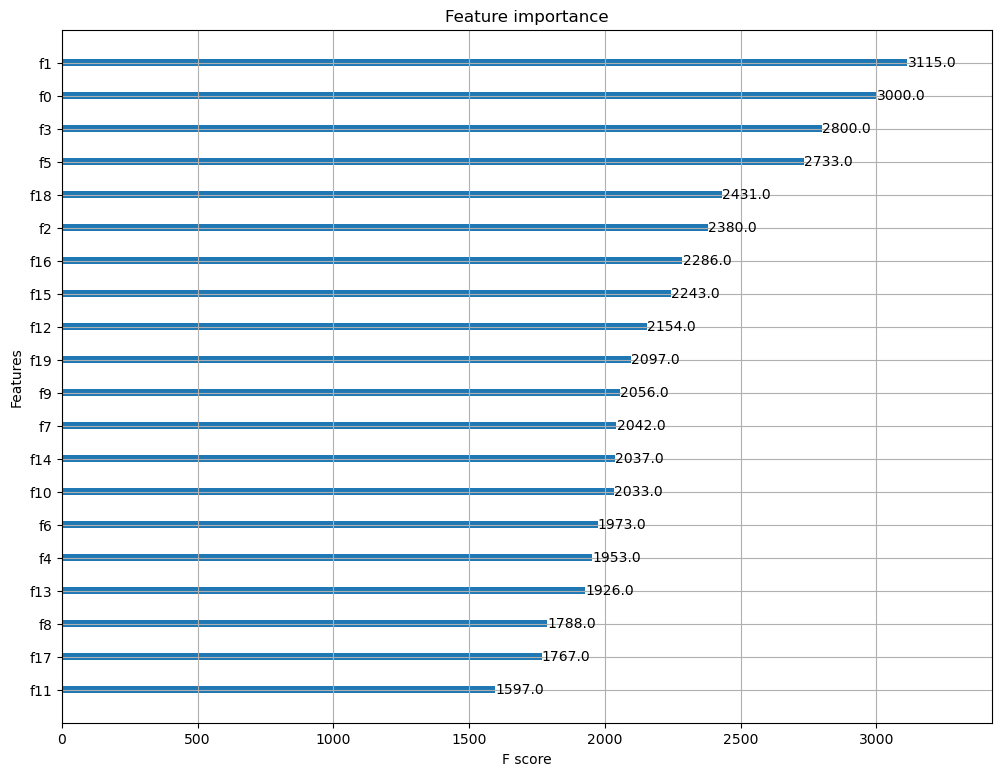

In [165]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12, 9]
plt.show()

## `Selected_Features`

### Neural Network: (`Selected_Features`)

In [87]:
table_cols = ['# of units per layer', '# of epochs', 'Size of batches']
table2 = pd.DataFrame(columns = table_cols)

param_sets = [[16,32,64],[256,200,16],[16,200,16],[16,128,16]]

for ps in param_sets:
    model = Sequential([
        Input(shape=(X_train_selected_scaled.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(rate=0.4),
        Dense(ps[0], activation='relu'),
        Dense(1, activation='relu')
    ])

    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=.001))


   
    train_start = dt.datetime.now()
    history = model.fit(X_train_selected_scaled, y_train, epochs=ps[1], batch_size=ps[2], verbose=0, validation_split=0.1)

    train_end = dt.datetime.now()
    train_duration = (train_end - train_start).total_seconds()
    
    y_train_pred = model.predict(X_train_selected_scaled)
    y_test_pred = model.predict(X_test_selected_scaled)
    
    # Compute RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Compute R-squared (R2)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Compute MAE
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    
    # Compute loss (mean squared error as a proxy for loss)
    loss_train = mean_squared_error(y_train, y_train_pred)
    loss_test = mean_squared_error(y_test, y_test_pred)
    
    run = pd.DataFrame({
        '# of units per layer': [ps[0]],
        '# of epochs': [ps[1]],
        'Size of batches': [ps[2]],
        'Training time': [train_duration],
        'Loss (Train)': [loss_train],
        'Loss (TEST)': [loss_test],
        'RMSE (Train)': [rmse_train],
        'RMSE (TEST)': [rmse_test],
        'R2 (Train)': [r2_train],
        'R2 (TEST)': [r2_test],
        'MAE (Train)': [mae_train],
        'MAE (TEST)': [mae_test]
    })
    
    table2 = pd.concat([table2, run], ignore_index=True)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


In [88]:
# results:
table2

# of units per layer # of epochs Size of batches  Training time  \
0                   16          32              64       3.692096   
1                  256         200              16      31.320140   
2                   16         200              16      27.973862   
3                   16         128              16      20.420817   

   Loss (Train)  Loss (TEST)  RMSE (Train)  RMSE (TEST)  R2 (Train)  \
0      2.335184     2.174313      1.528131     1.474555    0.516500   
1      0.820414     1.387802      0.905767     1.178050    0.830133   
2      0.933618     1.391563      0.966239     1.179645    0.806694   
3      1.143844     1.413223      1.069506     1.188791    0.763167   

   R2 (TEST)  MAE (Train)  MAE (TEST)  
0   0.536391     1.034369    1.135857  
1   0.704092     0.707147    0.919961  
2   0.703290     0.751252    0.915005  
3   0.698671     0.770759    0.929294

###  XGBoost: (`Selected_Features`)

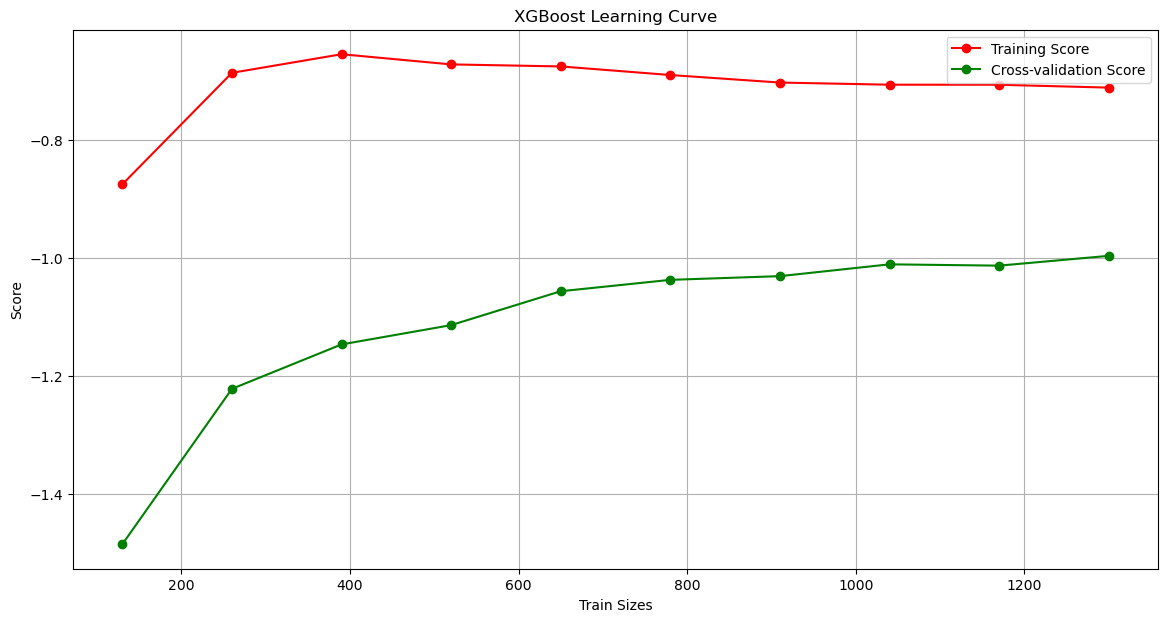

XGBoost (Training):
Mean Absolute Error (MAE): 0.6627285206542181
Root Mean Squared Error (RMSE): 0.8482878593363223
R-squared: 0.8510084041377163
********************************************************************************
XGBoost (TEST):
Mean Absolute Error (MAE): 0.809165829148597
Root Mean Squared Error (RMSE): 1.042862691280758
R-squared: 0.7681089913162328


In [167]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 5, alpha = 10, n_estimators = 1000)

xg_reg.fit(X_train_selected_scaled, y_train)

plot_learning_curve(xg_reg, X_train_selected_scaled, y_train, title='XGBoost Learning Curve')
print_evaluation_metrics(xg_reg, X_train_selected_scaled, y_train, title='XGBoost (Training)')
print("**" * 40)
print_evaluation_metrics(xg_reg, X_test_selected_scaled, y_test, title='XGBoost (TEST)')

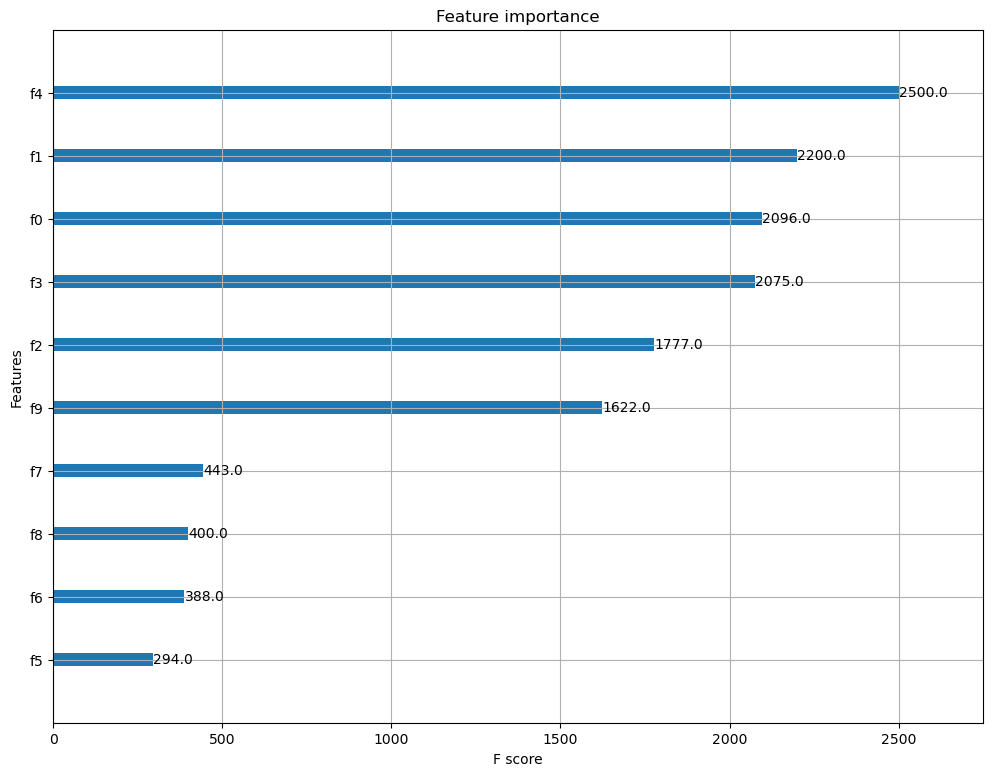

In [168]:

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12, 9]
plt.show()